In [413]:
att_cnn_bilstm_cross_validate_model_path = "saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5"
cnn_bilstm_cross_validate_model_path = "saved_model/best_CNN_BiLSTM_Cross_validation.hdf5"
cnn_cross_validate_model_path = "saved_model/best_CNN_Cross_validation.hdf5"
bisltm_cross_validate_model_path = "saved_model/best_BiLSTM_Cross_validation.hdf5"

# defining the hyperparameters
learning_rate = 1e-3
learning_decay = 1e-10 # 1e-4
batch_size= 64 # 128
epochs = 10

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.1 # 0.1 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.
embed_dim = 300 

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputSpec, Layer, Input, Embedding, Conv1D, Conv2D, Bidirectional, Dense, Attention
from tensorflow.keras.layers import LSTM, Activation, Add, Flatten, Concatenate, concatenate # CuDNNGRU, CuDNNLSTM, 
from tensorflow.keras.layers import Reshape, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, MaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam

import string
# from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

from glob import glob
from tqdm import tqdm

from time import time
from timeit import default_timer as timer
from datetime import datetime

import re, copy
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



In [414]:
import pandas as pd
import numpy as np
train_set = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/original/original_1/original_dataset_80_percent_1.csv", header= None,names=["text", "label"])
test_unseen = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/original/original_1/original_dataset_20_percent_1.csv",  header= None,names=["text", "label"])

# all_dataset =  pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/original/original_1/original_dataset.csv",  header= None,names=["text", "label"])

In [415]:
train_set

,text,label
0,สวัสดีค่ะ หนูได้โควตา Lg211 เซค แต่จดมะเบียนไม...,ลงทะเบียนเรียน
1,-สอบถามค่ะ ถ้าเป็นนักศึกษาแล้วอยู่ในสถานะชั้นป...,ลงทะเบียนเรียน
2,ขอสอบถามค่ะว่าถ้าถอนวิชา106เทอมนี้เเล้วติดwไว้...,เกรด
3,ตอนจ่ายค่าเทอมหนูชำระเงินเต็มจำนวนนะคะ แล้วกอง...,ชำระเงิน/ใบเสร็จรับเงิน
4,เพิ่มถอนวันไหนหรอคะ,ลงทะเบียนเรียน
...,...,...
2882,อยากสอบถามเรื่องถอนวิชาค่ะ 🥺,ลงทะเบียนเรียน
2883,สวัสดีค่ะ ช่วงเพิ่มถอน 6-15สค นี้สามารถเพิ่มถอ...,ลงทะเบียนเรียน
2884,รหัส60 ยังไม่สามารถขอสำเนา Transcript ได้ใช่มั...,ขอเอกสาร/ใบรับรอง
2885,ใช่ค่ะ ทราบว่าต้องไปส่งเองค่า แต่ต้องการเอกสาร...,ขอเอกสาร/ใบรับรอง


In [416]:
test_unseen

,text,label
0,อยากสอบถามอีกค่ะว่า นศ.ศูนย์ลำปาง สามารถลงเรีย...,ลงทะเบียนเรียน
1,เอกสารรับรองเช่นนี้อะค่ะ,ขอเอกสาร/ใบรับรอง
2,พอดีผมต้องใช้สมัครเนติบัณฑิตและสำนักอบรมวิชาว่...,ขอเอกสาร/ใบรับรอง
3,รายวิชาเต็มค่ะ,ลงทะเบียนเรียน
4,แล้วก็หนูส่งรูปใน TU Picnow ได้รับอนุมัติรูปแล...,แจ้งจบ/ขึ้นทะเบียนบัณฑิต
...,...,...
717,I have login into my acc but I haven't any opt...,ขอเอกสาร/ใบรับรอง
718,ก็คือถ้าหนู​เอาหนังสือ​ไปคืนวันนี้ ปุ่ม​ขึ้น​ท...,แจ้งจบ/ขึ้นทะเบียนบัณฑิต
719,สวัสดีค่ะ ตอนนี้เปิดให้นำใบเบิกค่าเทอมไปประทับ...,ขอเอกสาร/ใบรับรอง
720,ค่าจดทะเบียนภาคฤดูร้อนเท่าไหร่หรอคะ,ชำระเงิน/ใบเสร็จรับเงิน


In [417]:
from sklearn.model_selection import train_test_split
message_train, message_test, label_train, label_test = train_test_split(train_set["text"], train_set["label"], test_size=0.15,stratify=train_set["label"])

test = pd.DataFrame()
test["text"]=message_test
test["label"]=label_test


In [418]:
message_train_2, message_validation, label_train_2, label_validation = train_test_split(message_train, label_train, test_size=0.1765,stratify=label_train)
train = pd.DataFrame()
train["text"]=message_train_2
train["label"]=label_train_2

validate = pd.DataFrame()
validate["text"]=message_validation
validate["label"]=label_validation

In [419]:
validate["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           133
ลงทะเบียนเรียน              114
ชำระเงิน/ใบเสร็จรับเงิน      86
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     53
ประวัตินักศึกษา              18
สถานภาพนักศึกษา              15
เกรด                         14
Name: count, dtype: int64

In [420]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           620
ลงทะเบียนเรียน              533
ชำระเงิน/ใบเสร็จรับเงิน     398
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    249
ประวัตินักศึกษา              81
สถานภาพนักศึกษา              72
เกรด                         67
Name: count, dtype: int64

In [421]:
test_unseen["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           221
ลงทะเบียนเรียน              190
ชำระเงิน/ใบเสร็จรับเงิน     143
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     89
ประวัตินักศึกษา              29
สถานภาพนักศึกษา              26
เกรด                         24
Name: count, dtype: int64

In [422]:
test["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           133
ลงทะเบียนเรียน              114
ชำระเงิน/ใบเสร็จรับเงิน      86
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     53
ประวัตินักศึกษา              18
สถานภาพนักศึกษา              16
เกรด                         14
Name: count, dtype: int64

In [423]:
# all_dataset["label"].value_counts()

In [424]:
!pip install sklearn_crfsuite
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai=÷=1.0.46

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
# nltk.download('punkt')
# nltk.download('stopwords')
from pythainlp.corpus import thai_stopwords
stopwords = thai_stopwords()

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory


You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Installing build dependencies ... done
pythainlp requires Python '>=3.7' but the running Python is 2.7.16
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [425]:

# from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in word_tokenize(text,engine='newmm') if word not in (stopwords)])
    return text

In [426]:
def clean_text(text):
    # print(text)
    # text = lower_text(text)
    text_str = str(text)
    text = remove_number(text_str)
    text = remove_punct(text_str)
    text = remove_stopwords(text_str)

    return text

In [427]:
# all_dataset["clean_text"] = all_dataset["text"].apply(clean_text)
test_unseen["clean_text"] = test_unseen["text"].apply(clean_text)
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)
validate["clean_text"] =  validate["text"].apply(clean_text)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# all_dataset["encoded_original_label"] = label_encoder.fit_transform(all_dataset["label"])
test_unseen["encoded_original_label"] = label_encoder.fit_transform(test_unseen["label"])
test["encoded_original_label"] = label_encoder.fit_transform(test["label"])
train["encoded_original_label"] = label_encoder.fit_transform(train["label"])
validate["encoded_original_label"] = label_encoder.fit_transform(validate["label"])

In [428]:
from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential


act= "relu"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [429]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [430]:
!pip3 install textblob  

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip3: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems
###### https://arxiv.org/abs/1512.08756

In [431]:
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Hierarchical Attention Networks for Document Classification
##### http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

In [432]:
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
# https://www.kaggle.com/code/duykhanh99/bidirectional-lstm-cnn-attention-model/notebook
    
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}


class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
        
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config     
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Training the models

In [433]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results_cross_val = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])

In [434]:
test["encoded_original_label"]

647     3
1723    1
486     5
2846    1
1000    6
       ..
1009    3
1458    0
1627    6
1471    1
1253    0
Name: encoded_original_label, Length: 434, dtype: int64

In [435]:
X_train, X_test_unseen, X_test, X_validate = train["clean_text"], test_unseen["clean_text"], test["clean_text"], validate["clean_text"]


y_train, y_test_unseen, y_test, y_validate = train["encoded_original_label"], test_unseen["encoded_original_label"],test["encoded_original_label"],validate["encoded_original_label"]


temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate = X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate

# temp_message, temp_label = all_dataset["clean_text"], all_dataset["encoded_original_label"]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)

{'สอบถาม': 1, 'เอกสาร': 2, 'ค่า': 3, 'จบ': 4, 'เทอม': 5, 'วิชา': 6, 'สวัสดี': 7, 'จ่าย': 8, 'ไหม': 9, 'ใบ': 10, 'นักศึกษา': 11, 'เรื่อง': 12, 'ทำ': 13, 'หรอ': 14, 'หนู': 15, 'ผม': 16, 'แจ้ง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'tu': 21, 'ขึ้นทะเบียน': 22, 'วันที่': 23, 'ใบรับรอง': 24, 'ทราบ': 25, 'บัณฑิต': 26, 'อะ': 27, 'กด': 28, 'นะคะ': 29, 'ออนไลน์': 30, '2': 31, 'ชำระ': 32, 'ปี': 33, 'reg': 34, '1': 35, 'ตอน': 36, 'ต้องการ': 37, 'รายวิชา': 38, 'เงิน': 39, 'เกรด': 40, 'รบกวน': 41, 'ไห': 42, 'นคะ': 43, 'คณะ': 44, 'ชำระเงิน': 45, 'การศึกษา': 46, 'ตอนนี้': 47, 'ติดต่อ': 48, 'กี่': 49, 'หน่วยกิต': 50, 'รอ': 51, '3': 52, 'transcript': 53, 'จดทะเบียน': 54, 'รหัส': 55, 'ระบบ': 56, 'ป': 57, 'อ่ะ': 58, 'ตัว': 59, 'เว็บ': 60, 'ยื่น': 61, 'เบิก': 62, 'มหาลัย': 63, 'ค': 64, 'ซัมเมอร์': 65, 'ล่าช้า': 66, 'แบบนี้': 67, 'ใบเสร็จ': 68, 'สำนักทะเบียน': 69, 'สถานะ': 70, 'โควต้า': 71, 'ชื่อ': 72, 'ท': 73, 'เข้าไป': 74, 'สถานภาพ': 75, 'สอบ': 76, 'สค': 77, 'รูป': 78, 'ขออนุญาต': 79, 'w': 80, 'ข

In [436]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           620
ลงทะเบียนเรียน              533
ชำระเงิน/ใบเสร็จรับเงิน     398
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    249
ประวัตินักศึกษา              81
สถานภาพนักศึกษา              72
เกรด                         67
Name: count, dtype: int64

## Att CNN-BiLSTM MODEL

In [437]:
def build_model_1(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
#         optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_Attention_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="Att_cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history_1 = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history_1, train_time

In [438]:
# Train proposed model
model_1, history_1, train_time = build_model_1(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_85 (InputLayer)       [(None, 74)]              0         
                                                                 
 embedding (Embedding)       (None, 74, 300)           620400    
                                                                 
 spatial_dropout1d_128 (Spa  (None, 74, 300)           0         
 tialDropout1D)                                                  
                                                                 
 conv1d_106 (Conv1D)         (None, 72, 50)            45050     
                                                                 
 max_pooling1d_106 (MaxPool  (None, 36, 50)            0         
 ing1D)                                                          
                                                                 
 dropout_212 (Dropout)       (None, 36, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


31/32 [============================>.] - ETA: 0s - loss: 1.7360 - accuracy: 0.2707
Epoch 1: val_loss improved from inf to 1.66324, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_15-57-48.hdf5
32/32 [==============================] - 4s 56ms/step - loss: 1.7357 - accuracy: 0.2728 - val_loss: 1.6632 - val_accuracy: 0.3072
Epoch 2/10
 5/32 [===>..........................] - ETA: 0s - loss: 1.6696 - accuracy: 0.3031

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - ETA: 0s - loss: 1.6664 - accuracy: 0.3045
Epoch 2: val_loss improved from 1.66324 to 1.63245, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_15-57-48.hdf5
32/32 [==============================] - 1s 41ms/step - loss: 1.6664 - accuracy: 0.3045 - val_loss: 1.6324 - val_accuracy: 0.3303
Epoch 3/10
31/32 [============================>.] - ETA: 0s - loss: 1.3827 - accuracy: 0.5156
Epoch 3: val_loss improved from 1.63245 to 1.04190, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_15-57-48.hdf5
32/32 [==============================] - 1s 37ms/step - loss: 1.3818 - accuracy: 0.5168 - val_loss: 1.0419 - val_accuracy: 0.6882
Epoch 4/10
31/32 [============================>.] - ETA: 0s - loss: 0.8655 - accuracy: 0.7303
Epoch 4: val_loss improved from 1.04190 to 0.92064, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_15-57-48.hdf5
32/32 [==============================] - 1s 39ms/step - loss: 0.8707 - accuracy: 0

In [439]:

# Test 15%
predicted = model_1.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


14/14 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.8521    0.9098    0.8800       133
           1     0.7528    0.7791    0.7657        86
           2     0.2727    0.3333    0.3000        18
           3     0.8899    0.8509    0.8700       114
           4     0.2727    0.1875    0.2222        16
           5     0.5000    0.4286    0.4615        14
           6     0.7143    0.6604    0.6863        53

    accuracy                         0.7719       434
   macro avg     0.6078    0.5928    0.5980       434
weighted avg     0.7688    0.7719    0.7693       434

Testing Accuracy: 0.771889
Testing Precision: 0.768783
Testing Recall: 0.771889
Testing F1 score: 0.769253


In [440]:

df_results.loc['Att-Based CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366


Validate 15%

In [441]:
predicted_val = model_1.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

14/14 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0     0.8310    0.8872    0.8582       133
           1     0.7654    0.7209    0.7425        86
           2     0.3333    0.5000    0.4000        18
           3     0.8850    0.8772    0.8811       114
           4     0.4286    0.2000    0.2727        15
           5     0.3333    0.3571    0.3448        14
           6     0.7500    0.6792    0.7129        53

    accuracy                         0.7691       433
   macro avg     0.6181    0.6031    0.6017       433
weighted avg     0.7715    0.7691    0.7675       433

Testing Accuracy: 0.769053
Testing Precision: 0.771544
Testing Recall: 0.769053
Testing F1 score: 0.767519


In [442]:
df_results.loc['Att-Based CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366


In [443]:
print(X_test_unseen)

[[   1  118  171 ...    0    0    0]
 [   2   27    0 ...    0    0    0]
 [  16  149 1978 ...    0    0    0]
 ...
 [   7   47  299 ...    0    0    0]
 [   3   54  599 ...    0    0    0]
 [  47   44    2 ...    0    0    0]]


In [444]:
# Test unseen 15%

predicted_test_unseen = model_1.predict(X_test_unseen)
print(predicted_test_unseen)
predicted_test_unseen = np.argmax(predicted_test_unseen, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted_test_unseen, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted_test_unseen)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing F1 score: %f' % f1)

 1/23 [>.............................] - ETA: 0s

23/23 [==============================] - 0s 7ms/step
[[9.6455812e-03 7.6278967e-01 3.2028863e-03 ... 1.5760645e-02
  5.5741590e-02 9.5520169e-03]
 [9.7413242e-01 1.7591029e-02 3.9191623e-03 ... 1.8061229e-03
  1.1629688e-04 1.8839133e-03]
 [3.3830570e-03 1.2392352e-01 8.6804252e-04 ... 3.2359490e-03
  1.9674718e-02 3.9964961e-03]
 ...
 [9.8825711e-01 9.1810524e-03 1.2233980e-03 ... 4.3222096e-04
  2.9989951e-05 6.9346646e-04]
 [2.8706601e-04 1.4238201e-02 8.7609398e-05 ... 2.8502633e-04
  3.0622520e-03 6.3066377e-04]
 [2.6779288e-02 7.7335471e-03 4.0286136e-01 ... 3.1374261e-01
  3.5576771e-03 2.4448992e-01]]
              precision    recall  f1-score   support

           0     0.8250    0.8959    0.8590       221
           1     0.8308    0.7552    0.7912       143
           2     0.2750    0.3793    0.3188        29
           3     0.8811    0.8579    0.8693       190
           4     0.3889    0.2692    0.3182        26
           5     0.2759    0.3333    0.3019        24
    

In [445]:
df_results.loc['Att-Based CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366


In [446]:
print(X_train)
print()
print(y_train)

[[  1 348  26 ...   0   0   0]
 [  2 113  22 ...   0   0   0]
 [  1  12  22 ...   0   0   0]
 ...
 [145  44 143 ...   0   0   0]
 [  1  87  24 ...   0   0   0]
 [ 55 256  58 ...   0   0   0]]

[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [447]:
# Define model parameters
# MAX_NB_WORDS = 1000
# embed_dim = 100
# max_length = 100
# spa_dropout_ratio = 0.2
# lstm_units_1 = 64
# lstm_units_2 = 64
# dense_units = 32
# dropout_ratio = 0.5
# learning_rate = 0.001
# learning_decay = 1e-6

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_att_cnn_bilstm = []
precision_scores_att_cnn_bilstm = []
f1_scores_att_cnn_bilstm = []
recall_scores_att_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation]
fold_var = 0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
   
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    att_cnn_bilstm_model = Model(model_input, model_output)

    ######################## COMPILING THE MODEL ##################################
    att_cnn_bilstm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
        metrics = [
            "accuracy",
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    check_point = ModelCheckpoint(att_cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    callbacks_list = [check_point,early_stop]
    
    # Display a summary of the models structure
    print(att_cnn_bilstm_model.summary())
    print("#"*80)
   
    # Train the model
    start_time = time()
    att_cnn_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks_list, verbose=1)
    total_train_time += train_time 
    
    y_pred=np.argmax(att_cnn_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_att_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_att_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 1


Model: "model_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 74)]              0         
                                                                 
 embedding (Embedding)       (None, 74, 300)           620400    
                                                                 
 spatial_dropout1d_129 (Spa  (None, 74, 300)           0         
 tialDropout1D)                                                  
                                                                 
 conv1d_107 (Conv1D)         (None, 72, 50)            45050     
                                                                 
 max_pooling1d_107 (MaxPool  (None, 36, 50)            0         
 ing1D)                                                          
                                                                 
 dropout_214 (Dropout)       (None, 36, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


55/57 [===========================>..] - ETA: 0s - loss: 1.7159 - accuracy: 0.2688
Epoch 1: val_loss improved from inf to 1.65352, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 31ms/step - loss: 1.7168 - accuracy: 0.2662 - val_loss: 1.6535 - val_accuracy: 0.2624
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.6400 - accuracy: 0.3304

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.4644 - accuracy: 0.4369
Epoch 2: val_loss improved from 1.65352 to 1.03917, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 1.4546 - accuracy: 0.4395 - val_loss: 1.0392 - val_accuracy: 0.6238
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.9284 - accuracy: 0.6420
Epoch 3: val_loss improved from 1.03917 to 0.87121, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.9298 - accuracy: 0.6408 - val_loss: 0.8712 - val_accuracy: 0.6584
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.6579
Epoch 4: val_loss improved from 0.87121 to 0.82559, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 23ms/step - loss: 0.7848 - accuracy: 0.6579 - val_loss: 0.8

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - ETA: 0s - loss: 1.7186 - accuracy: 0.2805
Epoch 1: val_loss improved from inf to 1.65324, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 31ms/step - loss: 1.7186 - accuracy: 0.2805 - val_loss: 1.6532 - val_accuracy: 0.3069
Epoch 2/10
 6/57 [==>...........................] - ETA: 1s - loss: 1.6845 - accuracy: 0.3281

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.4514 - accuracy: 0.4384
Epoch 2: val_loss improved from 1.65324 to 1.06928, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 23ms/step - loss: 1.4514 - accuracy: 0.4384 - val_loss: 1.0693 - val_accuracy: 0.5990
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.8650 - accuracy: 0.6835
Epoch 3: val_loss improved from 1.06928 to 0.71425, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.8637 - accuracy: 0.6843 - val_loss: 0.7142 - val_accuracy: 0.7673
Epoch 4/10
55/57 [===========================>..] - ETA: 0s - loss: 0.5051 - accuracy: 0.8403
Epoch 4: val_loss improved from 0.71425 to 0.64056, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.5078 - accuracy: 0.8399 - val_loss: 0.6

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - ETA: 0s - loss: 1.7117 - accuracy: 0.2816
Epoch 1: val_loss improved from inf to 1.64956, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 31ms/step - loss: 1.7117 - accuracy: 0.2816 - val_loss: 1.6496 - val_accuracy: 0.3267
Epoch 2/10
 7/57 [==>...........................] - ETA: 1s - loss: 1.6438 - accuracy: 0.2857

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.3994 - accuracy: 0.4767
Epoch 2: val_loss improved from 1.64956 to 1.09467, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 1.3938 - accuracy: 0.4785 - val_loss: 1.0947 - val_accuracy: 0.6040
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.7910 - accuracy: 0.7466
Epoch 3: val_loss improved from 1.09467 to 0.85100, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.7992 - accuracy: 0.7453 - val_loss: 0.8510 - val_accuracy: 0.7327
Epoch 4/10
55/57 [===========================>..] - ETA: 0s - loss: 0.5464 - accuracy: 0.8244
Epoch 4: val_loss improved from 0.85100 to 0.77851, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 0.5385 - accuracy: 0.8273 - val_loss: 0.7

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


56/57 [============================>.] - ETA: 0s - loss: 1.6993 - accuracy: 0.2723
Epoch 1: val_loss improved from inf to 1.65537, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 35ms/step - loss: 1.7005 - accuracy: 0.2728 - val_loss: 1.6554 - val_accuracy: 0.3069
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.6218 - accuracy: 0.2545

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.5367 - accuracy: 0.3306
Epoch 2: val_loss improved from 1.65537 to 1.36793, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 23ms/step - loss: 1.5367 - accuracy: 0.3306 - val_loss: 1.3679 - val_accuracy: 0.3911
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.9418 - accuracy: 0.6659
Epoch 3: val_loss improved from 1.36793 to 0.78606, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.9343 - accuracy: 0.6694 - val_loss: 0.7861 - val_accuracy: 0.7772
Epoch 4/10
55/57 [===========================>..] - ETA: 0s - loss: 0.5573 - accuracy: 0.8205
Epoch 4: val_loss improved from 0.78606 to 0.73373, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 0.5555 - accuracy: 0.8223 - val_loss: 0.7

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


55/57 [===========================>..] - ETA: 0s - loss: 1.7069 - accuracy: 0.2722
Epoch 1: val_loss improved from inf to 1.65462, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 31ms/step - loss: 1.7068 - accuracy: 0.2750 - val_loss: 1.6546 - val_accuracy: 0.3069
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.6097 - accuracy: 0.2991

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.4782 - accuracy: 0.3577
Epoch 2: val_loss improved from 1.65462 to 1.19504, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 1.4731 - accuracy: 0.3608 - val_loss: 1.1950 - val_accuracy: 0.5248
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.8642 - accuracy: 0.6943
Epoch 3: val_loss improved from 1.19504 to 0.76773, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 23ms/step - loss: 0.8607 - accuracy: 0.6969 - val_loss: 0.7677 - val_accuracy: 0.7673
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.8471
Epoch 4: val_loss improved from 0.76773 to 0.59308, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 0.4799 - accuracy: 0.8471 - val_loss: 0.5

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


56/57 [============================>.] - ETA: 0s - loss: 1.7026 - accuracy: 0.2896
Epoch 1: val_loss improved from inf to 1.64634, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 33ms/step - loss: 1.7023 - accuracy: 0.2893 - val_loss: 1.6463 - val_accuracy: 0.3069
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.6757 - accuracy: 0.3170

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.3372 - accuracy: 0.5170
Epoch 2: val_loss improved from 1.64634 to 1.07840, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 1.3153 - accuracy: 0.5286 - val_loss: 1.0784 - val_accuracy: 0.6584
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.7852
Epoch 3: val_loss improved from 1.07840 to 0.91594, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 23ms/step - loss: 0.6594 - accuracy: 0.7871 - val_loss: 0.9159 - val_accuracy: 0.6980
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.8515
Epoch 4: val_loss did not improve from 0.91594
57/57 [==============================] - 1s 22ms/step - loss: 0.4493 - accuracy: 0.8515 - val_loss: 0.9535 - val_accuracy: 0.7129
Epoch 5/10
55/57 [===========================>..

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - ETA: 0s - loss: 1.7032 - accuracy: 0.2761
Epoch 1: val_loss improved from inf to 1.65378, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 32ms/step - loss: 1.7032 - accuracy: 0.2761 - val_loss: 1.6538 - val_accuracy: 0.3762
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.6637 - accuracy: 0.3214

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.4955 - accuracy: 0.4301
Epoch 2: val_loss improved from 1.65378 to 1.25323, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 1.4933 - accuracy: 0.4279 - val_loss: 1.2532 - val_accuracy: 0.5693
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 1.0176 - accuracy: 0.6105
Epoch 3: val_loss improved from 1.25323 to 1.03531, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 1.0138 - accuracy: 0.6100 - val_loss: 1.0353 - val_accuracy: 0.6287
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.6705
Epoch 4: val_loss improved from 1.03531 to 0.96326, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.7749 - accuracy: 0.6705 - val_loss: 0.9

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - ETA: 0s - loss: 1.7101 - accuracy: 0.2882
Epoch 1: val_loss improved from inf to 1.65151, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 6s 34ms/step - loss: 1.7101 - accuracy: 0.2882 - val_loss: 1.6515 - val_accuracy: 0.3069
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.6587 - accuracy: 0.2768

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.4520 - accuracy: 0.4543
Epoch 2: val_loss improved from 1.65151 to 0.90090, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 1.4520 - accuracy: 0.4543 - val_loss: 0.9009 - val_accuracy: 0.7178
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.7271 - accuracy: 0.7659
Epoch 3: val_loss improved from 0.90090 to 0.75595, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 0.7234 - accuracy: 0.7662 - val_loss: 0.7560 - val_accuracy: 0.7574
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.5019 - accuracy: 0.8516
Epoch 4: val_loss improved from 0.75595 to 0.66814, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 23ms/step - loss: 0.4974 - accuracy: 0.8531 - val_loss: 0.6

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - ETA: 0s - loss: 1.6961 - accuracy: 0.2772
Epoch 1: val_loss improved from inf to 1.66479, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 31ms/step - loss: 1.6961 - accuracy: 0.2772 - val_loss: 1.6648 - val_accuracy: 0.2624
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.7075 - accuracy: 0.2366

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.5122 - accuracy: 0.3636
Epoch 2: val_loss improved from 1.66479 to 1.24698, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 1.5122 - accuracy: 0.3636 - val_loss: 1.2470 - val_accuracy: 0.5891
Epoch 3/10
55/57 [===========================>..] - ETA: 0s - loss: 0.9743 - accuracy: 0.6244
Epoch 3: val_loss improved from 1.24698 to 0.92153, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.9810 - accuracy: 0.6249 - val_loss: 0.9215 - val_accuracy: 0.6337
Epoch 4/10
55/57 [===========================>..] - ETA: 0s - loss: 0.7315 - accuracy: 0.7153
Epoch 4: val_loss improved from 0.92153 to 0.79143, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.7297 - accuracy: 0.7167 - val_loss: 0.7

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


55/57 [===========================>..] - ETA: 0s - loss: 1.7208 - accuracy: 0.2881
Epoch 1: val_loss improved from inf to 1.65371, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 4s 32ms/step - loss: 1.7185 - accuracy: 0.2877 - val_loss: 1.6537 - val_accuracy: 0.3069
Epoch 2/10
 7/57 [==>...........................] - ETA: 0s - loss: 1.7468 - accuracy: 0.2634

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.4816 - accuracy: 0.4420
Epoch 2: val_loss improved from 1.65371 to 0.85097, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 21ms/step - loss: 1.4652 - accuracy: 0.4494 - val_loss: 0.8510 - val_accuracy: 0.7574
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7246 - accuracy: 0.7756
Epoch 3: val_loss improved from 0.85097 to 0.66168, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.7246 - accuracy: 0.7756 - val_loss: 0.6617 - val_accuracy: 0.7921
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.8366
Epoch 4: val_loss improved from 0.66168 to 0.57613, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 1s 22ms/step - loss: 0.4996 - accuracy: 0.8366 - val_loss: 0.5

In [448]:
accuracy_avg_att_cnn_bilstm = sum(accuracy_scores_att_cnn_bilstm) / len(accuracy_scores_att_cnn_bilstm)
precision_avg_att_cnn_bilstm = sum(precision_scores_att_cnn_bilstm) / len(precision_scores_att_cnn_bilstm)
recall_avg_att_cnn_bilstm = sum(recall_scores_att_cnn_bilstm) / len(recall_scores_att_cnn_bilstm)
f1_avg_att_cnn_bilstm = sum(f1_scores_att_cnn_bilstm) / len(f1_scores_att_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_att_cnn_bilstm,
    'Precision': precision_scores_att_cnn_bilstm,
    'Recall': recall_scores_att_cnn_bilstm,
    'F1 Score': f1_scores_att_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_att_cnn_bilstm,precision_avg_att_cnn_bilstm,recall_avg_att_cnn_bilstm,f1_avg_att_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.806931 |    0.815356 | 0.805008 |   0.805008 |
| 2      |   0.787129 |    0.783085 | 0.781036 |   0.781036 |
| 3      |   0.79703  |    0.834169 | 0.800074 |   0.800074 |
| 4      |   0.80198  |    0.802737 | 0.799789 |   0.799789 |
| 5      |   0.826733 |    0.831194 | 0.818675 |   0.818675 |
| 6      |   0.673267 |    0.707954 | 0.68024  |   0.68024  |
| 7      |   0.792079 |    0.800701 | 0.791769 |   0.791769 |
| 8      |   0.841584 |    0.846422 | 0.835684 |   0.835684 |
| 9      |   0.80198  |    0.820644 | 0.807473 |   0.807473 |
| 10     |   0.79703  |    0.799439 | 0.791281 |   0.791281 |
| Avg.   |   0.792574 |    0.80417  | 0.791103 |   0.791103 |


Average Acc. Cross validatiom

In [449]:
df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 80%'] = [f1_avg_att_cnn_bilstm, precision_avg_att_cnn_bilstm, recall_avg_att_cnn_bilstm, accuracy_avg_att_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.80417,0.791103,0.792574,155.263662


In [450]:
# Test cross validation 20%
# print(y_test_unseen)

model_att_cnn_bilstm_cross_validate = load_model(att_cnn_bilstm_cross_validate_model_path,custom_objects=create_custom_objects())

predictions = model_att_cnn_bilstm_cross_validate.predict(X_test_unseen)

# print(predictions)
# # Convert one-hot encoded predictions to class labels
# predicted_labels = np.argmax(predictions, axis=1)
predictions = np.argmax(predictions, axis=1)

report = classification_report(y_test_unseen, predictions, output_dict=True)
# # report = classification_report(y_test, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predictions)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predictions,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predictions,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predictions,average='weighted')
print('Testing F1 score: %f' % f1)

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


23/23 [==============================] - 1s 6ms/step
Testing Accuracy: 0.781163
Testing Precision: 0.768666
Testing Recall: 0.781163
Testing F1 score: 0.767544


In [451]:


df_results.loc['Att-Based CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366


### Plotting the results

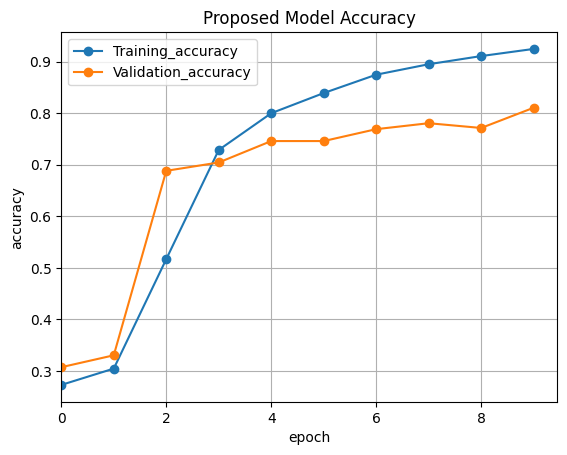

In [452]:
plt.plot(history_1.epoch, history_1.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('Proposed Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

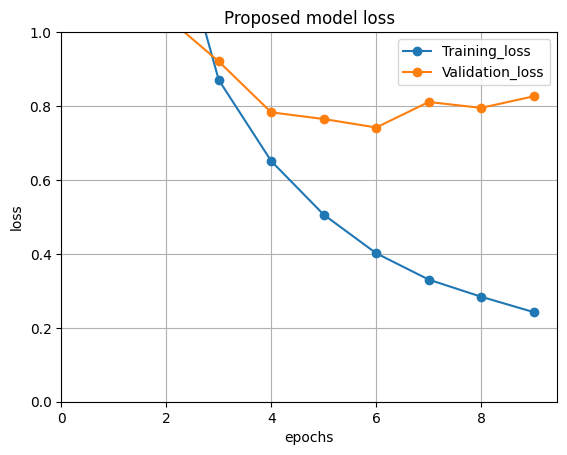

In [453]:
plt.plot(history_1.epoch, history_1.history['loss'], '-o', label='Training_loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Validation_loss')
plt.title('Proposed model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.close()

## CNN-BiLSTM MODEL

In [454]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'สอบถาม': 1, 'เอกสาร': 2, 'ค่า': 3, 'จบ': 4, 'เทอม': 5, 'วิชา': 6, 'สวัสดี': 7, 'จ่าย': 8, 'ไหม': 9, 'ใบ': 10, 'นักศึกษา': 11, 'เรื่อง': 12, 'ทำ': 13, 'หรอ': 14, 'หนู': 15, 'ผม': 16, 'แจ้ง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'tu': 21, 'ขึ้นทะเบียน': 22, 'วันที่': 23, 'ใบรับรอง': 24, 'ทราบ': 25, 'บัณฑิต': 26, 'อะ': 27, 'กด': 28, 'นะคะ': 29, 'ออนไลน์': 30, '2': 31, 'ชำระ': 32, 'ปี': 33, 'reg': 34, '1': 35, 'ตอน': 36, 'ต้องการ': 37, 'รายวิชา': 38, 'เงิน': 39, 'เกรด': 40, 'รบกวน': 41, 'ไห': 42, 'นคะ': 43, 'คณะ': 44, 'ชำระเงิน': 45, 'การศึกษา': 46, 'ตอนนี้': 47, 'ติดต่อ': 48, 'กี่': 49, 'หน่วยกิต': 50, 'รอ': 51, '3': 52, 'transcript': 53, 'จดทะเบียน': 54, 'รหัส': 55, 'ระบบ': 56, 'ป': 57, 'อ่ะ': 58, 'ตัว': 59, 'เว็บ': 60, 'ยื่น': 61, 'เบิก': 62, 'มหาลัย': 63, 'ค': 64, 'ซัมเมอร์': 65, 'ล่าช้า': 66, 'แบบนี้': 67, 'ใบเสร็จ': 68, 'สำนักทะเบียน': 69, 'สถานะ': 70, 'โควต้า': 71, 'ชื่อ': 72, 'ท': 73, 'เข้าไป': 74, 'สถานภาพ': 75, 'สอบ': 76, 'สค': 77, 'รูป': 78, 'ขออนุญาต': 79, 'w': 80, 'ข

In [455]:
# # check the shape of each set
# print("X_train shape: {}".format(X_train.shape))
# print("y_train shape: {}".format(y_train.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test_unseen shape: {}".format(X_test_unseen.shape))
# print("y_test_unseen shape: {}".format(y_test_unseen.shape))

In [456]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 2020 
Test set size = 722


In [457]:
import tensorflow as tf

def build_model_2(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history, train_time

In [458]:
# Train proposed model
model_2, history_5, train_time = build_model_2(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_96 (InputLayer)       [(None, 74)]              0         
                                                                 
 embedding_66 (Embedding)    (None, 74, 300)           620400    
                                                                 
 spatial_dropout1d_139 (Spa  (None, 74, 300)           0         
 tialDropout1D)                                                  
                                                                 
 conv1d_117 (Conv1D)         (None, 72, 50)            45050     
                                                                 
 max_pooling1d_117 (MaxPool  (None, 36, 50)            0         
 ing1D)                                                          
                                                                 
 dropout_234 (Dropout)       (None, 36, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/32 [============================>.] - ETA: 0s - loss: 1.4111 - accuracy: 0.5106
Epoch 2: val_loss improved from 1.63437 to 1.06965, saving model to saved_model/best_CNN_BiLSTM_20240210_16-00-32.hdf5
32/32 [==============================] - 1s 35ms/step - loss: 1.4030 - accuracy: 0.5129 - val_loss: 1.0697 - val_accuracy: 0.6420
Epoch 3/10
31/32 [============================>.] - ETA: 0s - loss: 0.9185 - accuracy: 0.6946
Epoch 3: val_loss improved from 1.06965 to 0.77598, saving model to saved_model/best_CNN_BiLSTM_20240210_16-00-32.hdf5
32/32 [==============================] - 1s 36ms/step - loss: 0.9188 - accuracy: 0.6950 - val_loss: 0.7760 - val_accuracy: 0.7621
Epoch 4/10
31/32 [============================>.] - ETA: 0s - loss: 0.6186 - accuracy: 0.8044
Epoch 4: val_loss improved from 0.77598 to 0.64539, saving model to saved_model/best_CNN_BiLSTM_20240210_16-00-32.hdf5
32/32 [==============================] - 1s 38ms/step - loss: 0.6154 - accuracy: 0.8054 - val_loss: 0.6454 - val

In [459]:
# Test 15%
predicted = model_2.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


14/14 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.8623    0.8947    0.8782       133
           1     0.7609    0.8140    0.7865        86
           2     0.2632    0.2778    0.2703        18
           3     0.7939    0.9123    0.8490       114
           4     0.5000    0.0625    0.1111        16
           5     0.0000    0.0000    0.0000        14
           6     0.8298    0.7358    0.7800        53

    accuracy                         0.7788       434
   macro avg     0.5729    0.5282    0.5250       434
weighted avg     0.7542    0.7788    0.7586       434

Testing Accuracy: 0.778802
Testing Precision: 0.754246
Testing Recall: 0.778802
Testing F1 score: 0.758551


In [460]:
df_results.loc['CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613


In [461]:
# Validate 15%
predicted_val = model_2.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

14/14 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0     0.8571    0.9023    0.8791       133
           1     0.8352    0.8837    0.8588        86
           2     0.3077    0.2222    0.2581        18
           3     0.8537    0.9211    0.8861       114
           4     1.0000    0.1333    0.2353        15
           5     0.1250    0.0714    0.0909        14
           6     0.7857    0.8302    0.8073        53

    accuracy                         0.8129       433
   macro avg     0.6806    0.5663    0.5737       433
weighted avg     0.8016    0.8129    0.7945       433

Testing Accuracy: 0.812933
Testing Precision: 0.801553
Testing Recall: 0.812933
Testing F1 score: 0.794515


In [462]:

df_results.loc['CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613


In [463]:
# Test unseen 15%

predicted = model_2.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

23/23 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0     0.8156    0.9005    0.8559       221
           1     0.8264    0.8322    0.8293       143
           2     0.2778    0.1724    0.2128        29
           3     0.8382    0.9000    0.8680       190
           4     0.4286    0.1154    0.1818        26
           5     0.1429    0.1250    0.1333        24
           6     0.7976    0.7528    0.7746        89

    accuracy                         0.7853       722
   macro avg     0.5896    0.5426    0.5508       722
weighted avg     0.7636    0.7853    0.7697       722

Testing Accuracy: 0.785319
Testing Precision: 0.763567
Testing Recall: 0.785319
Testing F1 score: 0.769668


In [464]:

# append the results
df_results.loc['CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613


In [465]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'สอบถาม': 1, 'เอกสาร': 2, 'ค่า': 3, 'จบ': 4, 'เทอม': 5, 'วิชา': 6, 'สวัสดี': 7, 'จ่าย': 8, 'ไหม': 9, 'ใบ': 10, 'นักศึกษา': 11, 'เรื่อง': 12, 'ทำ': 13, 'หรอ': 14, 'หนู': 15, 'ผม': 16, 'แจ้ง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'tu': 21, 'ขึ้นทะเบียน': 22, 'วันที่': 23, 'ใบรับรอง': 24, 'ทราบ': 25, 'บัณฑิต': 26, 'อะ': 27, 'กด': 28, 'นะคะ': 29, 'ออนไลน์': 30, '2': 31, 'ชำระ': 32, 'ปี': 33, 'reg': 34, '1': 35, 'ตอน': 36, 'ต้องการ': 37, 'รายวิชา': 38, 'เงิน': 39, 'เกรด': 40, 'รบกวน': 41, 'ไห': 42, 'นคะ': 43, 'คณะ': 44, 'ชำระเงิน': 45, 'การศึกษา': 46, 'ตอนนี้': 47, 'ติดต่อ': 48, 'กี่': 49, 'หน่วยกิต': 50, 'รอ': 51, '3': 52, 'transcript': 53, 'จดทะเบียน': 54, 'รหัส': 55, 'ระบบ': 56, 'ป': 57, 'อ่ะ': 58, 'ตัว': 59, 'เว็บ': 60, 'ยื่น': 61, 'เบิก': 62, 'มหาลัย': 63, 'ค': 64, 'ซัมเมอร์': 65, 'ล่าช้า': 66, 'แบบนี้': 67, 'ใบเสร็จ': 68, 'สำนักทะเบียน': 69, 'สถานะ': 70, 'โควต้า': 71, 'ชื่อ': 72, 'ท': 73, 'เข้าไป': 74, 'สถานภาพ': 75, 'สอบ': 76, 'สค': 77, 'รูป': 78, 'ขออนุญาต': 79, 'w': 80, 'ข

In [466]:

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_cnn_bilstm = []
precision_scores_cnn_bilstm = []
f1_scores_cnn_bilstm = []
recall_scores_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time

# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    cnn_bisltm_model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    cnn_bisltm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT #################################
    check_point = ModelCheckpoint(cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(cnn_bisltm_model.summary())
    print("#"*80)
    # tf.keras.utils.plot_model(cnn_bisltm_model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_bisltm_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cnn_bisltm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))



------ Fold ---------- 2
Model: "model_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_97 (InputLayer)       [(None, 74)]              0         
                                                                 
 embedding_67 (Embedding)    (None, 74, 300)           620400    
                                                                 
 spatial_dropout1d_140 (Spa  (None, 74, 300)           0         
 tialDropout1D)                                                  
                                                                 
 conv1d_118 (Conv1D)         (None, 72, 50)            45050     
                                                                 
 max_pooling1d_118 (MaxPool  (None, 36, 50)            0         
 ing1D)                                                          
                                                                 
 dropout_236 (Dropout)       (Non

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/29 [===========================>..] - ETA: 0s - loss: 1.5780 - accuracy: 0.4146
Epoch 2: val_loss improved from 1.64744 to 1.29550, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 41ms/step - loss: 1.5753 - accuracy: 0.4169 - val_loss: 1.2955 - val_accuracy: 0.5644
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 1.1211 - accuracy: 0.6199
Epoch 3: val_loss improved from 1.29550 to 1.01584, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 1.1211 - accuracy: 0.6199 - val_loss: 1.0158 - val_accuracy: 0.6436
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.9124 - accuracy: 0.7090
Epoch 4: val_loss improved from 1.01584 to 0.85080, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 0.9124 - accuracy: 0.7090 - val_loss: 0.8508 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 1.6272 - accuracy: 0.3592
Epoch 2: val_loss improved from 1.64887 to 1.49122, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 1.6272 - accuracy: 0.3592 - val_loss: 1.4912 - val_accuracy: 0.4406
Epoch 3/10
27/29 [==========================>...] - ETA: 0s - loss: 1.1162 - accuracy: 0.6487
Epoch 3: val_loss improved from 1.49122 to 0.83188, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.0998 - accuracy: 0.6562 - val_loss: 0.8319 - val_accuracy: 0.7475
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.8152
Epoch 4: val_loss improved from 0.83188 to 0.66866, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 0.6206 - accuracy: 0.8152 - val_loss: 0.6687 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 1.5977 - accuracy: 0.3570
Epoch 2: val_loss improved from 1.66116 to 1.47773, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 1.5977 - accuracy: 0.3570 - val_loss: 1.4777 - val_accuracy: 0.4010
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 1.1890 - accuracy: 0.5671
Epoch 3: val_loss improved from 1.47773 to 1.28186, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.1890 - accuracy: 0.5671 - val_loss: 1.2819 - val_accuracy: 0.6139
Epoch 4/10
27/29 [==========================>...] - ETA: 0s - loss: 0.7885 - accuracy: 0.7795
Epoch 4: val_loss improved from 1.28186 to 1.04182, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 0.7854 - accuracy: 0.7805 - val_loss: 1.0418 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/29 [===========================>..] - ETA: 0s - loss: 1.6088 - accuracy: 0.3571
Epoch 2: val_loss improved from 1.65075 to 1.44098, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 1.6101 - accuracy: 0.3564 - val_loss: 1.4410 - val_accuracy: 0.4752
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 1.2076 - accuracy: 0.5666
Epoch 3: val_loss improved from 1.44098 to 1.04698, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.2076 - accuracy: 0.5666 - val_loss: 1.0470 - val_accuracy: 0.6287
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.6975
Epoch 4: val_loss improved from 1.04698 to 0.81427, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 0.8740 - accuracy: 0.6975 - val_loss: 0.8143 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/29 [==========================>...] - ETA: 0s - loss: 1.5858 - accuracy: 0.4028
Epoch 2: val_loss improved from 1.65414 to 1.32927, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.5743 - accuracy: 0.4164 - val_loss: 1.3293 - val_accuracy: 0.6040
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.6991
Epoch 3: val_loss improved from 1.32927 to 0.80551, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.0111 - accuracy: 0.6991 - val_loss: 0.8055 - val_accuracy: 0.7673
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.8141
Epoch 4: val_loss improved from 0.80551 to 0.71478, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 0.6315 - accuracy: 0.8141 - val_loss: 0.7148 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/29 [==========================>...] - ETA: 0s - loss: 1.6276 - accuracy: 0.3472
Epoch 2: val_loss improved from 1.66165 to 1.54093, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 1.6330 - accuracy: 0.3454 - val_loss: 1.5409 - val_accuracy: 0.4455
Epoch 3/10
27/29 [==========================>...] - ETA: 0s - loss: 1.1284 - accuracy: 0.6690
Epoch 3: val_loss improved from 1.54093 to 0.93646, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 1.1127 - accuracy: 0.6749 - val_loss: 0.9365 - val_accuracy: 0.6832
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.8212
Epoch 4: val_loss improved from 0.93646 to 0.91368, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 0.6007 - accuracy: 0.8212 - val_loss: 0.9137 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/29 [==========================>...] - ETA: 0s - loss: 1.6028 - accuracy: 0.3779
Epoch 2: val_loss improved from 1.64323 to 1.38422, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.5937 - accuracy: 0.3834 - val_loss: 1.3842 - val_accuracy: 0.5594
Epoch 3/10
27/29 [==========================>...] - ETA: 0s - loss: 1.0312 - accuracy: 0.6921
Epoch 3: val_loss improved from 1.38422 to 0.86400, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.0268 - accuracy: 0.6931 - val_loss: 0.8640 - val_accuracy: 0.7673
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.8273
Epoch 4: val_loss improved from 0.86400 to 0.71950, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 0.6166 - accuracy: 0.8273 - val_loss: 0.7195 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 1.5717 - accuracy: 0.4109
Epoch 2: val_loss improved from 1.65183 to 1.30843, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 1.5717 - accuracy: 0.4109 - val_loss: 1.3084 - val_accuracy: 0.5446
Epoch 3/10
27/29 [==========================>...] - ETA: 0s - loss: 1.0438 - accuracy: 0.6574
Epoch 3: val_loss improved from 1.30843 to 0.86184, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.0288 - accuracy: 0.6645 - val_loss: 0.8618 - val_accuracy: 0.7079
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7987
Epoch 4: val_loss improved from 0.86184 to 0.71359, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 0.6715 - accuracy: 0.7987 - val_loss: 0.7136 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/29 [==========================>...] - ETA: 0s - loss: 1.5424 - accuracy: 0.4346
Epoch 2: val_loss improved from 1.63956 to 1.17406, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 1.5302 - accuracy: 0.4400 - val_loss: 1.1741 - val_accuracy: 0.6535
Epoch 3/10
27/29 [==========================>...] - ETA: 0s - loss: 0.9399 - accuracy: 0.7332
Epoch 3: val_loss improved from 1.17406 to 0.70851, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 35ms/step - loss: 0.9308 - accuracy: 0.7371 - val_loss: 0.7085 - val_accuracy: 0.7822
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.8212
Epoch 4: val_loss improved from 0.70851 to 0.62218, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 0.5812 - accuracy: 0.8212 - val_loss: 0.6222 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 1.6114 - accuracy: 0.3328
Epoch 2: val_loss improved from 1.64907 to 1.44487, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 34ms/step - loss: 1.6114 - accuracy: 0.3328 - val_loss: 1.4449 - val_accuracy: 0.6139
Epoch 3/10
28/29 [===========================>..] - ETA: 0s - loss: 1.0987 - accuracy: 0.6802
Epoch 3: val_loss improved from 1.44487 to 0.74230, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 38ms/step - loss: 1.0901 - accuracy: 0.6832 - val_loss: 0.7423 - val_accuracy: 0.7871
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.8097
Epoch 4: val_loss improved from 0.74230 to 0.65301, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 0.6196 - accuracy: 0.8097 - val_loss: 0.6530 - val_ac

In [467]:
accuracy_avg_cnn_bilstm = sum(accuracy_scores_cnn_bilstm) / len(accuracy_scores_cnn_bilstm)
precision_avg_cnn_bilstm = sum(precision_scores_cnn_bilstm) / len(precision_scores_cnn_bilstm)
recall_avg_cnn_bilstm = sum(recall_scores_cnn_bilstm) / len(recall_scores_cnn_bilstm)
f1_avg_cnn_bilstm = sum(f1_scores_cnn_bilstm) / len(f1_scores_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_cnn_bilstm,
    'Precision': precision_scores_cnn_bilstm,
    'Recall': recall_scores_cnn_bilstm,
    'F1 Score': f1_scores_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_cnn_bilstm,precision_avg_cnn_bilstm,recall_avg_cnn_bilstm,f1_avg_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.767327 |    0.782747 | 0.770757 |   0.770757 |
| 2      |   0.816832 |    0.811975 | 0.811041 |   0.811041 |
| 3      |   0.742574 |    0.776236 | 0.752663 |   0.752663 |
| 4      |   0.831683 |    0.82738  | 0.825481 |   0.825481 |
| 5      |   0.792079 |    0.79704  | 0.782879 |   0.782879 |
| 6      |   0.732673 |    0.720106 | 0.722725 |   0.722725 |
| 7      |   0.767327 |    0.802698 | 0.778005 |   0.778005 |
| 8      |   0.836634 |    0.834201 | 0.830119 |   0.830119 |
| 9      |   0.826733 |    0.840163 | 0.829061 |   0.829061 |
| 10     |   0.816832 |    0.830375 | 0.819487 |   0.819487 |
| Avg.   |   0.793069 |    0.802292 | 0.792222 |   0.792222 |


In [468]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data train 80%'] = [f1_avg_cnn_bilstm, precision_avg_cnn_bilstm, recall_avg_cnn_bilstm, accuracy_avg_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.804170,0.791103,0.792574,155.263662
CNN-BiLSTM avg cross validation data train 80%,0.792222,0.802292,0.792222,0.793069,122.956128


In [469]:
# Test cross validation 20%
model_bilstm_cross_validate = load_model(cnn_bilstm_cross_validate_model_path)
predicted = model_bilstm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

23/23 [==============================] - 1s 5ms/step
Testing Accuracy: 0.810249
Testing Precision: 0.808747
Testing Recall: 0.810249
Testing F1 score: 0.804681


In [470]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.804170,0.791103,0.792574,155.263662
CNN-BiLSTM avg cross validation data train 80%,0.792222,0.802292,0.792222,0.793069,122.956128
CNN-BiLSTM avg cross validation data test 20%,0.804681,0.808747,0.810249,0.810249,12.295613


### Plotting the results

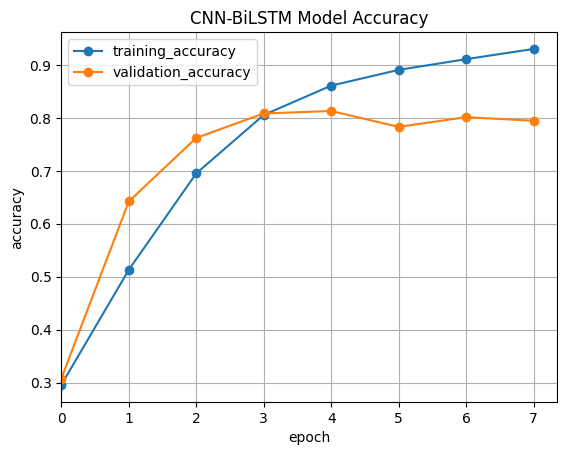

In [471]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


plt.plot(history_5.epoch, history_5.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='validation_accuracy')
plt.title('CNN-BiLSTM Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

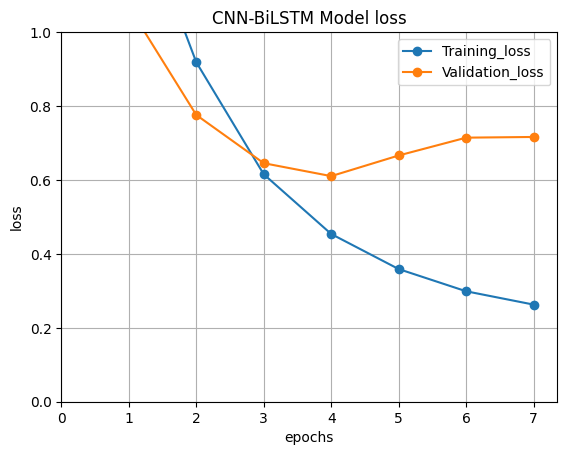

In [472]:
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_5.epoch, history_5.history['loss'], '-o', label='Training_loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='Validation_loss')
plt.title('CNN-BiLSTM Model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# BASELINES MODELS

## 1D CNN MODEL

In [473]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

# ### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'สอบถาม': 1, 'เอกสาร': 2, 'ค่า': 3, 'จบ': 4, 'เทอม': 5, 'วิชา': 6, 'สวัสดี': 7, 'จ่าย': 8, 'ไหม': 9, 'ใบ': 10, 'นักศึกษา': 11, 'เรื่อง': 12, 'ทำ': 13, 'หรอ': 14, 'หนู': 15, 'ผม': 16, 'แจ้ง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'tu': 21, 'ขึ้นทะเบียน': 22, 'วันที่': 23, 'ใบรับรอง': 24, 'ทราบ': 25, 'บัณฑิต': 26, 'อะ': 27, 'กด': 28, 'นะคะ': 29, 'ออนไลน์': 30, '2': 31, 'ชำระ': 32, 'ปี': 33, 'reg': 34, '1': 35, 'ตอน': 36, 'ต้องการ': 37, 'รายวิชา': 38, 'เงิน': 39, 'เกรด': 40, 'รบกวน': 41, 'ไห': 42, 'นคะ': 43, 'คณะ': 44, 'ชำระเงิน': 45, 'การศึกษา': 46, 'ตอนนี้': 47, 'ติดต่อ': 48, 'กี่': 49, 'หน่วยกิต': 50, 'รอ': 51, '3': 52, 'transcript': 53, 'จดทะเบียน': 54, 'รหัส': 55, 'ระบบ': 56, 'ป': 57, 'อ่ะ': 58, 'ตัว': 59, 'เว็บ': 60, 'ยื่น': 61, 'เบิก': 62, 'มหาลัย': 63, 'ค': 64, 'ซัมเมอร์': 65, 'ล่าช้า': 66, 'แบบนี้': 67, 'ใบเสร็จ': 68, 'สำนักทะเบียน': 69, 'สถานะ': 70, 'โควต้า': 71, 'ชื่อ': 72, 'ท': 73, 'เข้าไป': 74, 'สถานภาพ': 75, 'สอบ': 76, 'สค': 77, 'รูป': 78, 'ขออนุญาต': 79, 'w': 80, 'ข

In [474]:

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test_unseen shape: {}".format(X_test_unseen.shape))
print("y_test_unseen shape: {}".format(y_test_unseen.shape))

X_train shape: (2020, 74)
y_train shape: (2020, 7)
X_test_unseen shape: (722, 74)
y_test_unseen shape: (722, 7)


In [475]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 2020 
Test set size = 434


In [476]:
#Model Definition
model_3 = Sequential()
model_3.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
# model.add(Dropout(0.25))
model_3.add(SpatialDropout1D(spa_dropout_ratio))

model_3.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
model_3.add(Dense(dense_units, activation='relu'))
model_3.add(Flatten()) # no need if used Global poooling
model_3.add(Dropout(dropout_ratio))

model_3.add(Dense(7, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))
######################## COMPILING THE MODEL ##################################
model_3.compile(
    loss = "categorical_crossentropy", 
   optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#       "binary_accuracy",
        'categorical_accuracy',
#       tf.keras.metrics.AUC(),
#       tf.keras.metrics.Precision(),
#       tf.keras.metrics.Recall()
        ]
    )

print(model_3.summary())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 74, 300)           620400    
                                                                 
 spatial_dropout1d_150 (Spa  (None, 74, 300)           0         
 tialDropout1D)                                                  
                                                                 
 conv1d_128 (Conv1D)         (None, 72, 50)            45050     
                                                                 
 max_pooling1d_128 (MaxPool  (None, 36, 50)            0         
 ing1D)                                                          
                                                                 
 dense_300 (Dense)           (None, 36, 64)            3264      
                                                                 
 flatten_22 (Flatten)        (None, 2304)            

In [477]:
checkpoint = ModelCheckpoint("saved_model/"+"1D_CNN_"+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint, earlystopping]

# fit network
start_time = time()
history_2 = model_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
29/32 [==========================>...] - ETA: 0s - loss: 1.7017 - accuracy: 0.3060 - categorical_accuracy: 0.3060
Epoch 1: loss improved from inf to 1.69862, saving model to saved_model/1D_CNN_20240210_16:02:51.h5
32/32 [==============================] - 1s 15ms/step - loss: 1.6986 - accuracy: 0.3069 - categorical_accuracy: 0.3069 - val_loss: 1.6298 - val_accuracy: 0.3072 - val_categorical_accuracy: 0.3072
Epoch 2/10
19/32 [================>.............] - ETA: 0s - loss: 1.5638 - accuracy: 0.3799 - categorical_accuracy: 0.3799

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/32 [===========================>..] - ETA: 0s - loss: 1.4600 - accuracy: 0.4818 - categorical_accuracy: 0.4818
Epoch 2: loss improved from 1.69862 to 1.44075, saving model to saved_model/1D_CNN_20240210_16:02:51.h5
32/32 [==============================] - 0s 11ms/step - loss: 1.4407 - accuracy: 0.4941 - categorical_accuracy: 0.4941 - val_loss: 1.1138 - val_accuracy: 0.6813 - val_categorical_accuracy: 0.6813
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.7698 - categorical_accuracy: 0.7698
Epoch 3: loss improved from 1.44075 to 0.78945, saving model to saved_model/1D_CNN_20240210_16:02:51.h5
32/32 [==============================] - 0s 12ms/step - loss: 0.7895 - accuracy: 0.7698 - categorical_accuracy: 0.7698 - val_loss: 0.6761 - val_accuracy: 0.8083 - val_categorical_accuracy: 0.8083
Epoch 4/10
28/32 [=========================>....] - ETA: 0s - loss: 0.4768 - accuracy: 0.8571 - categorical_accuracy: 0.8571
Epoch 4: loss improved from 0.78945 

In [478]:
# Test 15%
predicted = model_3.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8741    0.8872    0.8806       133
           1     0.8140    0.8140    0.8140        86
           2     0.4500    0.5000    0.4737        18
           3     0.8547    0.8772    0.8658       114
           4     0.5600    0.8750    0.6829        16
           5     0.3333    0.2143    0.2609        14
           6     0.8571    0.6792    0.7579        53

    accuracy                         0.8065       434
   macro avg     0.6776    0.6924    0.6765       434
weighted avg     0.8084    0.8065    0.8044       434

Testing Accuracy: 0.806452
Testing Precision: 0.808394
Testing Recall: 0.806452
Testing F1 score: 0.804365


In [479]:

df_results.loc['1D_CNN Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613
1D_CNN Test 15%,0.804365,0.808394,0.806452,0.806452,4.245448


In [480]:
# append the results

predicted = model_3.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)



23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8604    0.8643    0.8623       221
           1     0.8429    0.8252    0.8339       143
           2     0.4359    0.5862    0.5000        29
           3     0.8579    0.8579    0.8579       190
           4     0.7143    0.7692    0.7407        26
           5     0.5333    0.3333    0.4103        24
           6     0.7955    0.7865    0.7910        89

    accuracy                         0.8130       722
   macro avg     0.7200    0.7175    0.7137       722
weighted avg     0.8151    0.8130    0.8128       722

Testing Accuracy: 0.813019
Testing Precision: 0.815064
Testing Recall: 0.813019
Testing F1 score: 0.812771


In [481]:
df_results.loc['1D_CNN Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613
1D_CNN Test 15%,0.804365,0.808394,0.806452,0.806452,4.245448
1D_CNN Test unseen 20%,0.812771,0.815064,0.813019,0.813019,4.245448


In [482]:
# Validate 15%
predicted_val = model_3.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)


14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8810    0.8346    0.8571       133
           1     0.7935    0.8488    0.8202        86
           2     0.4737    0.5000    0.4865        18
           3     0.8718    0.8947    0.8831       114
           4     0.7143    0.6667    0.6897        15
           5     0.4286    0.2143    0.2857        14
           6     0.7586    0.8302    0.7928        53

    accuracy                         0.8129       433
   macro avg     0.7031    0.6842    0.6879       433
weighted avg     0.8089    0.8129    0.8091       433

Testing Accuracy: 0.812933
Testing Precision: 0.808864
Testing Recall: 0.812933
Testing F1 score: 0.809086


In [483]:
df_results.loc['1D_CNN Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613
1D_CNN Test 15%,0.804365,0.808394,0.806452,0.806452,4.245448
1D_CNN Test unseen 20%,0.812771,0.815064,0.813019,0.813019,4.245448
1D_CNN Validate 15%,0.809086,0.808864,0.812933,0.812933,4.245448


In [484]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_1d_cnn = []
precision_scores_1d_cnn = []
f1_scores_1d_cnn = []
recall_scores_1d_cnn = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    #Model Definition
    cnn_model = Sequential()
    cnn_model.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
    # model.add(Dropout(0.25))
    cnn_model.add(SpatialDropout1D(spa_dropout_ratio))

    cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    # model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(dense_units, activation='relu'))
    cnn_model.add(Flatten()) # no need if used Global poooling
    cnn_model.add(Dropout(dropout_ratio))

    cnn_model.add(Dense(7, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    ######################## COMPILING THE MODEL ##################################
    cnn_model.compile(
        loss = "categorical_crossentropy", 
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
    #         optimizer='adam',
        metrics = [
            "accuracy",
    #       "binary_accuracy",
            'categorical_accuracy',
    #       tf.keras.metrics.AUC(),
    #       tf.keras.metrics.Precision(),
    #       tf.keras.metrics.Recall()
            ]
        )
    
   
    check_point = ModelCheckpoint(cnn_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time  
    
    y_pred=np.argmax(cnn_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_1d_cnn.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_1d_cnn.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 2
Epoch 1/10
28/29 [===========================>..] - ETA: 0s - loss: 1.6883 - accuracy: 0.2974 - categorical_accuracy: 0.2974
Epoch 1: val_loss improved from inf to 1.61839, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 1s 14ms/step - loss: 1.6875 - accuracy: 0.2970 - categorical_accuracy: 0.2970 - val_loss: 1.6184 - val_accuracy: 0.3119 - val_categorical_accuracy: 0.3119
Epoch 2/10
18/29 [=================>............] - ETA: 0s - loss: 1.5455 - accuracy: 0.4497 - categorical_accuracy: 0.4497

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/29 [=======================>......] - ETA: 0s - loss: 1.5099 - accuracy: 0.4857 - categorical_accuracy: 0.4857
Epoch 2: val_loss improved from 1.61839 to 1.17287, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 11ms/step - loss: 1.4813 - accuracy: 0.5094 - categorical_accuracy: 0.5094 - val_loss: 1.1729 - val_accuracy: 0.6634 - val_categorical_accuracy: 0.6634
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7734 - categorical_accuracy: 0.7734
Epoch 3: val_loss improved from 1.17287 to 0.71003, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 13ms/step - loss: 0.8142 - accuracy: 0.7734 - categorical_accuracy: 0.7734 - val_loss: 0.7100 - val_accuracy: 0.7673 - val_categorical_accuracy: 0.7673
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.4993 - accuracy: 0.8444 - categorical_accuracy: 0.8444
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/29 [===========================>..] - ETA: 0s - loss: 1.5085 - accuracy: 0.4810 - categorical_accuracy: 0.4810
Epoch 2: val_loss improved from 1.63743 to 1.30758, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 13ms/step - loss: 1.5118 - accuracy: 0.4813 - categorical_accuracy: 0.4813 - val_loss: 1.3076 - val_accuracy: 0.6436 - val_categorical_accuracy: 0.6436
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 0.9614 - accuracy: 0.7462 - categorical_accuracy: 0.7462
Epoch 3: val_loss improved from 1.30758 to 0.78903, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 0.9320 - accuracy: 0.7536 - categorical_accuracy: 0.7536 - val_loss: 0.7890 - val_accuracy: 0.7822 - val_categorical_accuracy: 0.7822
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8306 - categorical_accuracy: 0.8306
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/29 [========================>.....] - ETA: 0s - loss: 1.6867 - accuracy: 0.3019 - categorical_accuracy: 0.3019
Epoch 1: val_loss improved from inf to 1.63812, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 1s 14ms/step - loss: 1.6902 - accuracy: 0.3020 - categorical_accuracy: 0.3020 - val_loss: 1.6381 - val_accuracy: 0.3069 - val_categorical_accuracy: 0.3069
Epoch 2/10
18/29 [=================>............] - ETA: 0s - loss: 1.5796 - accuracy: 0.4314 - categorical_accuracy: 0.4314

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - ETA: 0s - loss: 1.5162 - accuracy: 0.4895 - categorical_accuracy: 0.4895
Epoch 2: val_loss improved from 1.63812 to 1.32837, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 11ms/step - loss: 1.5162 - accuracy: 0.4895 - categorical_accuracy: 0.4895 - val_loss: 1.3284 - val_accuracy: 0.6386 - val_categorical_accuracy: 0.6386
Epoch 3/10
24/29 [=======================>......] - ETA: 0s - loss: 0.9720 - accuracy: 0.7227 - categorical_accuracy: 0.7227
Epoch 3: val_loss improved from 1.32837 to 0.84568, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 0.9170 - accuracy: 0.7376 - categorical_accuracy: 0.7376 - val_loss: 0.8457 - val_accuracy: 0.7228 - val_categorical_accuracy: 0.7228
Epoch 4/10
24/29 [=======================>......] - ETA: 0s - loss: 0.5371 - accuracy: 0.8333 - categorical_accuracy: 0.8333
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/29 [=======================>......] - ETA: 0s - loss: 1.5773 - accuracy: 0.4180 - categorical_accuracy: 0.4180
Epoch 2: val_loss improved from 1.64959 to 1.36651, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.5502 - accuracy: 0.4373 - categorical_accuracy: 0.4373 - val_loss: 1.3665 - val_accuracy: 0.5297 - val_categorical_accuracy: 0.5297
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 1.0421 - accuracy: 0.7144 - categorical_accuracy: 0.7144
Epoch 3: val_loss improved from 1.36651 to 0.77934, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.0212 - accuracy: 0.7151 - categorical_accuracy: 0.7151 - val_loss: 0.7793 - val_accuracy: 0.7574 - val_categorical_accuracy: 0.7574
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.6077 - accuracy: 0.8075 - categorical_accuracy: 0.8075
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/29 [========================>.....] - ETA: 0s - loss: 1.5523 - accuracy: 0.4644 - categorical_accuracy: 0.4644
Epoch 2: val_loss improved from 1.64431 to 1.30554, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.5237 - accuracy: 0.4818 - categorical_accuracy: 0.4818 - val_loss: 1.3055 - val_accuracy: 0.6188 - val_categorical_accuracy: 0.6188
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 1.0511 - accuracy: 0.6819 - categorical_accuracy: 0.6819
Epoch 3: val_loss improved from 1.30554 to 0.79894, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.0089 - accuracy: 0.6892 - categorical_accuracy: 0.6892 - val_loss: 0.7989 - val_accuracy: 0.7129 - val_categorical_accuracy: 0.7129
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.5763 - accuracy: 0.8244 - categorical_accuracy: 0.8244
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/29 [========================>.....] - ETA: 0s - loss: 1.5477 - accuracy: 0.4387 - categorical_accuracy: 0.4387
Epoch 2: val_loss improved from 1.64491 to 1.32468, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.5192 - accuracy: 0.4521 - categorical_accuracy: 0.4521 - val_loss: 1.3247 - val_accuracy: 0.5990 - val_categorical_accuracy: 0.5990
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 0.9303 - accuracy: 0.7412 - categorical_accuracy: 0.7412
Epoch 3: val_loss improved from 1.32468 to 0.90646, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 0.9163 - accuracy: 0.7415 - categorical_accuracy: 0.7415 - val_loss: 0.9065 - val_accuracy: 0.7475 - val_categorical_accuracy: 0.7475
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.5438 - accuracy: 0.8475 - categorical_accuracy: 0.8475
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/29 [======================>.......] - ETA: 0s - loss: 1.5223 - accuracy: 0.4885 - categorical_accuracy: 0.4885
Epoch 2: val_loss improved from 1.62916 to 1.26315, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 11ms/step - loss: 1.4748 - accuracy: 0.5165 - categorical_accuracy: 0.5165 - val_loss: 1.2632 - val_accuracy: 0.5990 - val_categorical_accuracy: 0.5990
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 0.9350 - accuracy: 0.7156 - categorical_accuracy: 0.7156
Epoch 3: val_loss improved from 1.26315 to 0.84351, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 0.9053 - accuracy: 0.7217 - categorical_accuracy: 0.7217 - val_loss: 0.8435 - val_accuracy: 0.7723 - val_categorical_accuracy: 0.7723
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.5183 - accuracy: 0.8438 - categorical_accuracy: 0.8438
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/29 [========================>.....] - ETA: 0s - loss: 1.5724 - accuracy: 0.4550 - categorical_accuracy: 0.4550
Epoch 2: val_loss improved from 1.63563 to 1.39105, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.5570 - accuracy: 0.4780 - categorical_accuracy: 0.4780 - val_loss: 1.3911 - val_accuracy: 0.6584 - val_categorical_accuracy: 0.6584
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 1.0302 - accuracy: 0.7325 - categorical_accuracy: 0.7325
Epoch 3: val_loss improved from 1.39105 to 0.76910, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 0.9981 - accuracy: 0.7343 - categorical_accuracy: 0.7343 - val_loss: 0.7691 - val_accuracy: 0.7921 - val_categorical_accuracy: 0.7921
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.5545 - accuracy: 0.8319 - categorical_accuracy: 0.8319
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/29 [========================>.....] - ETA: 0s - loss: 1.5322 - accuracy: 0.4581 - categorical_accuracy: 0.4581
Epoch 2: val_loss improved from 1.63328 to 1.20152, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.5007 - accuracy: 0.4752 - categorical_accuracy: 0.4752 - val_loss: 1.2015 - val_accuracy: 0.6188 - val_categorical_accuracy: 0.6188
Epoch 3/10
24/29 [=======================>......] - ETA: 0s - loss: 0.9436 - accuracy: 0.7331 - categorical_accuracy: 0.7331
Epoch 3: val_loss improved from 1.20152 to 0.74121, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 13ms/step - loss: 0.9251 - accuracy: 0.7393 - categorical_accuracy: 0.7393 - val_loss: 0.7412 - val_accuracy: 0.7822 - val_categorical_accuracy: 0.7822
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.5625 - accuracy: 0.8294 - categorical_accuracy: 0.8294
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/29 [========================>.....] - ETA: 0s - loss: 1.5451 - accuracy: 0.5194 - categorical_accuracy: 0.5194
Epoch 2: val_loss improved from 1.62462 to 1.22936, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 1.5117 - accuracy: 0.5374 - categorical_accuracy: 0.5374 - val_loss: 1.2294 - val_accuracy: 0.6337 - val_categorical_accuracy: 0.6337
Epoch 3/10
25/29 [========================>.....] - ETA: 0s - loss: 0.9360 - accuracy: 0.7325 - categorical_accuracy: 0.7325
Epoch 3: val_loss improved from 1.22936 to 0.70549, saving model to saved_model/best_CNN_Cross_validation.hdf5
29/29 [==============================] - 0s 10ms/step - loss: 0.9079 - accuracy: 0.7415 - categorical_accuracy: 0.7415 - val_loss: 0.7055 - val_accuracy: 0.8020 - val_categorical_accuracy: 0.8020
Epoch 4/10
25/29 [========================>.....] - ETA: 0s - loss: 0.5192 - accuracy: 0.8375 - categorical_accuracy: 0.8375
Epoch 4: val_loss impr

In [485]:
accuracy_avg_1d_cnn = sum(accuracy_scores_1d_cnn) / len(accuracy_scores_1d_cnn)
precision_avg_1d_cnn = sum(precision_scores_1d_cnn) / len(precision_scores_1d_cnn)
recall_avg_1d_cnn = sum(recall_scores_1d_cnn) / len(recall_scores_1d_cnn)
f1_avg_1d_cnn = sum(f1_scores_1d_cnn) / len(f1_scores_1d_cnn)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_1d_cnn,
    'Precision': precision_scores_1d_cnn,
    'Recall': recall_scores_1d_cnn,
    'F1 Score': f1_scores_1d_cnn
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_1d_cnn,precision_avg_1d_cnn,recall_avg_1d_cnn,f1_avg_1d_cnn]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.792079 |    0.790688 | 0.787534 |   0.787534 |
| 2      |   0.806931 |    0.765679 | 0.781289 |   0.781289 |
| 3      |   0.782178 |    0.797413 | 0.785728 |   0.785728 |
| 4      |   0.79703  |    0.806975 | 0.798989 |   0.798989 |
| 5      |   0.836634 |    0.849467 | 0.836964 |   0.836964 |
| 6      |   0.762376 |    0.763126 | 0.759185 |   0.759185 |
| 7      |   0.782178 |    0.782136 | 0.77881  |   0.77881  |
| 8      |   0.856436 |    0.864098 | 0.8562   |   0.8562   |
| 9      |   0.846535 |    0.851309 | 0.846691 |   0.846691 |
| 10     |   0.831683 |    0.852342 | 0.827483 |   0.827483 |
| Avg.   |   0.809406 |    0.812323 | 0.805887 |   0.805887 |


In [486]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 80%'] = [f1_avg_1d_cnn, precision_avg_1d_cnn, recall_avg_1d_cnn, accuracy_avg_1d_cnn, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.804170,0.791103,0.792574,155.263662
CNN-BiLSTM avg cross validation data train 80%,0.792222,0.802292,0.792222,0.793069,122.956128
CNN-BiLSTM avg cross validation data test 20%,0.804681,0.808747,0.810249,0.810249,12.295613
1D_CNN avg cross validation data test 80%,0.805887,0.812323,0.805887,0.809406,42.454481


In [487]:
# Test cross validation 20%
model_cnn_cross_validate = load_model(cnn_cross_validate_model_path)
predicted = model_cnn_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

23/23 [==============================] - 0s 2ms/step
Testing Accuracy: 0.801939
Testing Precision: 0.801736
Testing Recall: 0.801939
Testing F1 score: 0.786249


In [488]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.804170,0.791103,0.792574,155.263662
CNN-BiLSTM avg cross validation data train 80%,0.792222,0.802292,0.792222,0.793069,122.956128
CNN-BiLSTM avg cross validation data test 20%,0.804681,0.808747,0.810249,0.810249,12.295613
1D_CNN avg cross validation data test 80%,0.805887,0.812323,0.805887,0.809406,42.454481
1D_CNN avg cross validation data test 20%,0.786249,0.801736,0.801939,0.801939,4.245448


### **Plotting the results**

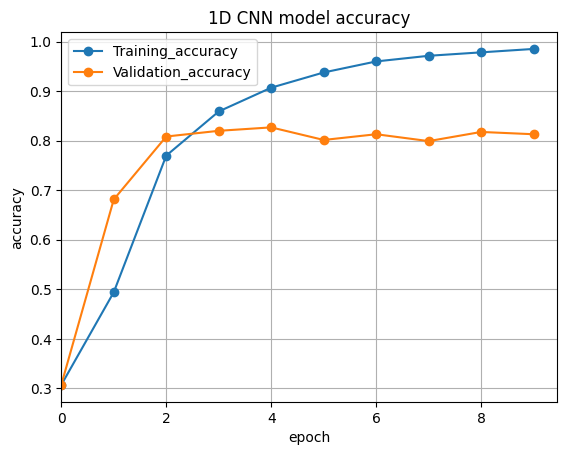

In [489]:
plt.plot(history_2.epoch, history_2.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('1D CNN model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

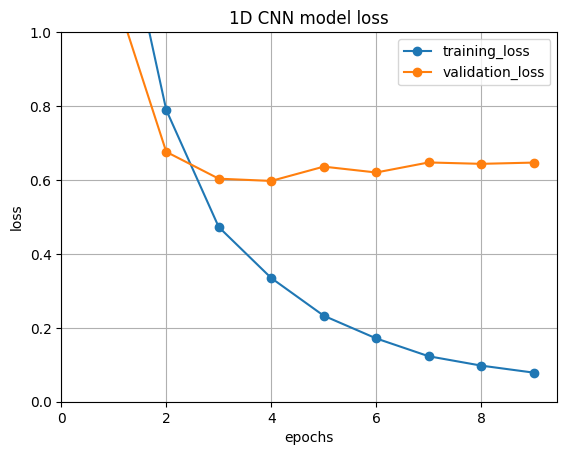

In [490]:
plt.plot(history_2.epoch, history_2.history['loss'], '-o', label='training_loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.title('1D CNN model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

## BiLSTM MODEL

In [491]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'สอบถาม': 1, 'เอกสาร': 2, 'ค่า': 3, 'จบ': 4, 'เทอม': 5, 'วิชา': 6, 'สวัสดี': 7, 'จ่าย': 8, 'ไหม': 9, 'ใบ': 10, 'นักศึกษา': 11, 'เรื่อง': 12, 'ทำ': 13, 'หรอ': 14, 'หนู': 15, 'ผม': 16, 'แจ้ง': 17, 'ถอน': 18, 'เรียน': 19, 'ลงทะเบียน': 20, 'tu': 21, 'ขึ้นทะเบียน': 22, 'วันที่': 23, 'ใบรับรอง': 24, 'ทราบ': 25, 'บัณฑิต': 26, 'อะ': 27, 'กด': 28, 'นะคะ': 29, 'ออนไลน์': 30, '2': 31, 'ชำระ': 32, 'ปี': 33, 'reg': 34, '1': 35, 'ตอน': 36, 'ต้องการ': 37, 'รายวิชา': 38, 'เงิน': 39, 'เกรด': 40, 'รบกวน': 41, 'ไห': 42, 'นคะ': 43, 'คณะ': 44, 'ชำระเงิน': 45, 'การศึกษา': 46, 'ตอนนี้': 47, 'ติดต่อ': 48, 'กี่': 49, 'หน่วยกิต': 50, 'รอ': 51, '3': 52, 'transcript': 53, 'จดทะเบียน': 54, 'รหัส': 55, 'ระบบ': 56, 'ป': 57, 'อ่ะ': 58, 'ตัว': 59, 'เว็บ': 60, 'ยื่น': 61, 'เบิก': 62, 'มหาลัย': 63, 'ค': 64, 'ซัมเมอร์': 65, 'ล่าช้า': 66, 'แบบนี้': 67, 'ใบเสร็จ': 68, 'สำนักทะเบียน': 69, 'สถานะ': 70, 'โควต้า': 71, 'ชื่อ': 72, 'ท': 73, 'เข้าไป': 74, 'สถานภาพ': 75, 'สอบ': 76, 'สค': 77, 'รูป': 78, 'ขออนุญาต': 79, 'w': 80, 'ข

In [492]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 2020 
Test set size = 722


In [493]:
#Model Definition
model_4 = Sequential()
model_4.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
# model.add(Dropout(0.25))
model_4.add(SpatialDropout1D(spa_dropout_ratio))

# model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))

model_4.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
# model.add(Dropout(dropout_ratio))
model_4.add(Bidirectional(LSTM(lstm_units_2)))
model_4.add(Dense(dense_units, activation='relu'))
model_4.add(Dropout(dropout_ratio))

model_4.add(Dense(7, activation='softmax'))
    
######################## COMPILING THE MODEL ##################################
model_4.compile(
    loss = "categorical_crossentropy", 
     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )

print(model_4.summary())

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, 74, 300)           620400    
                                                                 
 spatial_dropout1d_161 (Spa  (None, 74, 300)           0         
 tialDropout1D)                                                  
                                                                 
 bidirectional_256 (Bidirec  (None, 74, 128)           186880    
 tional)                                                         
                                                                 
 bidirectional_257 (Bidirec  (None, 64)                41216     
 tional)                                                         
                                                                 
 dense_322 (Dense)           (None, 64)                4160      
                                                     

In [494]:
checkpoint = ModelCheckpoint("saved_model/"+"BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint,earlystopping]

# fit network
start_time = time()
history_4 = model_4.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 1.7225 - accuracy: 0.2896 - categorical_accuracy: 0.2896
Epoch 1: loss improved from inf to 1.72248, saving model to saved_model/BiLSTM_20240210_16-03-26.h5
32/32 [==============================] - 5s 99ms/step - loss: 1.7225 - accuracy: 0.2896 - categorical_accuracy: 0.2896 - val_loss: 1.6036 - val_accuracy: 0.3741 - val_categorical_accuracy: 0.3741
Epoch 2/10
 2/32 [>.............................] - ETA: 2s - loss: 1.6085 - accuracy: 0.3281 - categorical_accuracy: 0.3281

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - ETA: 0s - loss: 1.3662 - accuracy: 0.5465 - categorical_accuracy: 0.5465
Epoch 2: loss improved from 1.72248 to 1.36616, saving model to saved_model/BiLSTM_20240210_16-03-26.h5
32/32 [==============================] - 3s 83ms/step - loss: 1.3662 - accuracy: 0.5465 - categorical_accuracy: 0.5465 - val_loss: 0.9944 - val_accuracy: 0.7182 - val_categorical_accuracy: 0.7182
Epoch 3/10
31/32 [============================>.] - ETA: 0s - loss: 0.7552 - accuracy: 0.7853 - categorical_accuracy: 0.7853
Epoch 3: loss improved from 1.36616 to 0.74954, saving model to saved_model/BiLSTM_20240210_16-03-26.h5
32/32 [==============================] - 3s 83ms/step - loss: 0.7495 - accuracy: 0.7866 - categorical_accuracy: 0.7866 - val_loss: 0.6621 - val_accuracy: 0.7783 - val_categorical_accuracy: 0.7783
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.8381 - categorical_accuracy: 0.8381
Epoch 4: loss improved from 0.74954 

In [495]:
# Test 15%
predicted = model_4.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


14/14 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0     0.8686    0.8947    0.8815       133
           1     0.7423    0.8372    0.7869        86
           2     0.5200    0.7222    0.6047        18
           3     0.8679    0.8070    0.8364       114
           4     0.7500    0.9375    0.8333        16
           5     0.6667    0.2857    0.4000        14
           6     0.8837    0.7170    0.7917        53

    accuracy                         0.8134       434
   macro avg     0.7570    0.7431    0.7335       434
weighted avg     0.8199    0.8134    0.8111       434

Testing Accuracy: 0.813364
Testing Precision: 0.819895
Testing Recall: 0.813364
Testing F1 score: 0.811129


In [496]:
df_results.loc['BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613
1D_CNN Test 15%,0.804365,0.808394,0.806452,0.806452,4.245448
1D_CNN Test unseen 20%,0.812771,0.815064,0.813019,0.813019,4.245448
1D_CNN Validate 15%,0.809086,0.808864,0.812933,0.812933,4.245448


In [497]:
# Validate 15%
predicted_val = model_4.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

df_results.loc['BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

14/14 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0     0.8712    0.8647    0.8679       133
           1     0.8043    0.8605    0.8315        86
           2     0.4667    0.7778    0.5833        18
           3     0.9174    0.8772    0.8969       114
           4     0.6667    0.6667    0.6667        15
           5     0.6250    0.3571    0.4545        14
           6     0.8723    0.7736    0.8200        53

    accuracy                         0.8291       433
   macro avg     0.7462    0.7396    0.7315       433
weighted avg     0.8384    0.8291    0.8303       433

Testing Accuracy: 0.829099
Testing Precision: 0.838375
Testing Recall: 0.829099
Testing F1 score: 0.830266


,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613
1D_CNN Test 15%,0.804365,0.808394,0.806452,0.806452,4.245448
1D_CNN Test unseen 20%,0.812771,0.815064,0.813019,0.813019,4.245448
1D_CNN Validate 15%,0.809086,0.808864,0.812933,0.812933,4.245448


In [498]:
predicted = model_4.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

23/23 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0     0.8326    0.9005    0.8652       221
           1     0.8429    0.8252    0.8339       143
           2     0.4651    0.6897    0.5556        29
           3     0.8889    0.8421    0.8649       190
           4     0.7600    0.7308    0.7451        26
           5     0.8000    0.5000    0.6154        24
           6     0.8625    0.7753    0.8166        89

    accuracy                         0.8269       722
   macro avg     0.7789    0.7519    0.7567       722
weighted avg     0.8347    0.8269    0.8279       722

Testing Accuracy: 0.826870
Testing Precision: 0.834683
Testing Recall: 0.826870
Testing F1 score: 0.827861


In [499]:
# append the results
df_results.loc['BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.769253,0.768783,0.771889,0.771889,15.526366
Att-Based CNN-BiLSTM Validate 15%,0.767519,0.771544,0.769053,0.769053,15.526366
Att-Based CNN-BiLSTM Test unseen 20%,0.768784,0.774065,0.767313,0.767313,15.526366
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.767544,0.768666,0.781163,0.781163,15.526366
CNN-BiLSTM Test 15%,0.758551,0.754246,0.778802,0.778802,12.295613
CNN-BiLSTM Validate 15%,0.794515,0.801553,0.812933,0.812933,12.295613
CNN-BiLSTM Test unseen 20%,0.769668,0.763567,0.785319,0.785319,12.295613
1D_CNN Test 15%,0.804365,0.808394,0.806452,0.806452,4.245448
1D_CNN Test unseen 20%,0.812771,0.815064,0.813019,0.813019,4.245448
1D_CNN Validate 15%,0.809086,0.808864,0.812933,0.812933,4.245448


In [500]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_bilstm = []
precision_scores_bilstm = []
f1_scores_bilstm = []
recall_scores_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var=0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # Define your Keras model
    cross_bilstm_model = Sequential()
    cross_bilstm_model.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
    cross_bilstm_model.add(SpatialDropout1D(spa_dropout_ratio))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_1, return_sequences=True)))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_2)))
    cross_bilstm_model.add(Dense(dense_units, activation='relu'))
    cross_bilstm_model.add(Dropout(dropout_ratio))
    cross_bilstm_model.add(Dense(7, activation='softmax'))

    # Compile the model
    cross_bilstm_model.compile(
        loss="categorical_crossentropy",
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
       metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
   
    check_point = ModelCheckpoint(bisltm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)

    # Train the model
    start_time = time()
    cross_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cross_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))

------ Fold ---------- 1
Epoch 1/10
56/57 [============================>.] - ETA: 0s - loss: 1.6345 - accuracy: 0.3504 - categorical_accuracy: 0.3504
Epoch 1: val_loss improved from inf to 1.27440, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 6s 65ms/step - loss: 1.6303 - accuracy: 0.3537 - categorical_accuracy: 0.3537 - val_loss: 1.2744 - val_accuracy: 0.6436 - val_categorical_accuracy: 0.6436
Epoch 2/10
 3/57 [>.............................] - ETA: 2s - loss: 1.3119 - accuracy: 0.6042 - categorical_accuracy: 0.6042

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.7081 - categorical_accuracy: 0.7081
Epoch 2: val_loss improved from 1.27440 to 0.68767, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 53ms/step - loss: 0.9423 - accuracy: 0.7096 - categorical_accuracy: 0.7096 - val_loss: 0.6877 - val_accuracy: 0.7723 - val_categorical_accuracy: 0.7723
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.8298 - categorical_accuracy: 0.8298
Epoch 3: val_loss improved from 0.68767 to 0.58669, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 57ms/step - loss: 0.5296 - accuracy: 0.8311 - categorical_accuracy: 0.8311 - val_loss: 0.5867 - val_accuracy: 0.8218 - val_categorical_accuracy: 0.8218
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.3745 - accuracy: 0.8811 - categorical_accuracy: 0.8811
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.0057 - accuracy: 0.6540 - categorical_accuracy: 0.6540
Epoch 2: val_loss improved from 1.29121 to 0.76474, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 55ms/step - loss: 1.0024 - accuracy: 0.6557 - categorical_accuracy: 0.6557 - val_loss: 0.7647 - val_accuracy: 0.7525 - val_categorical_accuracy: 0.7525
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.5778 - accuracy: 0.8131 - categorical_accuracy: 0.8131
Epoch 3: val_loss improved from 0.76474 to 0.71624, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 56ms/step - loss: 0.5788 - accuracy: 0.8119 - categorical_accuracy: 0.8119 - val_loss: 0.7162 - val_accuracy: 0.7624 - val_categorical_accuracy: 0.7624
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.8504 - categorical_accuracy: 0.8504
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.9417 - accuracy: 0.6942 - categorical_accuracy: 0.6942
Epoch 2: val_loss improved from 1.33103 to 0.89859, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 55ms/step - loss: 0.9382 - accuracy: 0.6964 - categorical_accuracy: 0.6964 - val_loss: 0.8986 - val_accuracy: 0.7327 - val_categorical_accuracy: 0.7327
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.8175 - categorical_accuracy: 0.8175
Epoch 3: val_loss improved from 0.89859 to 0.66762, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 58ms/step - loss: 0.5756 - accuracy: 0.8174 - categorical_accuracy: 0.8174 - val_loss: 0.6676 - val_accuracy: 0.7822 - val_categorical_accuracy: 0.7822
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.3793 - accuracy: 0.8823 - categorical_accuracy: 0.8823
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.8671 - accuracy: 0.7366 - categorical_accuracy: 0.7366
Epoch 2: val_loss improved from 1.25839 to 0.61924, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 52ms/step - loss: 0.8631 - accuracy: 0.7382 - categorical_accuracy: 0.7382 - val_loss: 0.6192 - val_accuracy: 0.8218 - val_categorical_accuracy: 0.8218
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.4523 - accuracy: 0.8538 - categorical_accuracy: 0.8538
Epoch 3: val_loss improved from 0.61924 to 0.58121, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 54ms/step - loss: 0.4489 - accuracy: 0.8548 - categorical_accuracy: 0.8548 - val_loss: 0.5812 - val_accuracy: 0.8119 - val_categorical_accuracy: 0.8119
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.9186 - categorical_accuracy: 0.9186
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.7585 - categorical_accuracy: 0.7585
Epoch 2: val_loss improved from 1.39034 to 0.65855, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 53ms/step - loss: 0.8920 - accuracy: 0.7585 - categorical_accuracy: 0.7585 - val_loss: 0.6586 - val_accuracy: 0.8069 - val_categorical_accuracy: 0.8069
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.5218 - accuracy: 0.8376 - categorical_accuracy: 0.8376
Epoch 3: val_loss improved from 0.65855 to 0.59652, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 56ms/step - loss: 0.5217 - accuracy: 0.8377 - categorical_accuracy: 0.8377 - val_loss: 0.5965 - val_accuracy: 0.8168 - val_categorical_accuracy: 0.8168
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8878 - categorical_accuracy: 0.8878
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.9462 - accuracy: 0.6964 - categorical_accuracy: 0.6964
Epoch 2: val_loss improved from 1.26695 to 0.86062, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 52ms/step - loss: 0.9429 - accuracy: 0.6969 - categorical_accuracy: 0.6969 - val_loss: 0.8606 - val_accuracy: 0.7277 - val_categorical_accuracy: 0.7277
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.5659 - accuracy: 0.8304 - categorical_accuracy: 0.8304
Epoch 3: val_loss improved from 0.86062 to 0.85356, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 54ms/step - loss: 0.5619 - accuracy: 0.8317 - categorical_accuracy: 0.8317 - val_loss: 0.8536 - val_accuracy: 0.7426 - val_categorical_accuracy: 0.7426
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.3995 - accuracy: 0.8778 - categorical_accuracy: 0.8778
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.6980 - categorical_accuracy: 0.6980
Epoch 2: val_loss improved from 1.36479 to 0.85690, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 52ms/step - loss: 1.0212 - accuracy: 0.6980 - categorical_accuracy: 0.6980 - val_loss: 0.8569 - val_accuracy: 0.7624 - val_categorical_accuracy: 0.7624
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.8240 - categorical_accuracy: 0.8240
Epoch 3: val_loss improved from 0.85690 to 0.74559, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 54ms/step - loss: 0.6040 - accuracy: 0.8240 - categorical_accuracy: 0.8240 - val_loss: 0.7456 - val_accuracy: 0.7624 - val_categorical_accuracy: 0.7624
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.3985 - accuracy: 0.8739 - categorical_accuracy: 0.8739
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.9192 - accuracy: 0.7394 - categorical_accuracy: 0.7394
Epoch 2: val_loss improved from 1.42287 to 0.67518, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 56ms/step - loss: 0.9098 - accuracy: 0.7420 - categorical_accuracy: 0.7420 - val_loss: 0.6752 - val_accuracy: 0.7822 - val_categorical_accuracy: 0.7822
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.8460 - categorical_accuracy: 0.8460
Epoch 3: val_loss improved from 0.67518 to 0.56207, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 55ms/step - loss: 0.4805 - accuracy: 0.8465 - categorical_accuracy: 0.8465 - val_loss: 0.5621 - val_accuracy: 0.8317 - val_categorical_accuracy: 0.8317
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.9124 - categorical_accuracy: 0.9124
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.9713 - accuracy: 0.7093 - categorical_accuracy: 0.7093
Epoch 2: val_loss improved from 1.48638 to 0.63814, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 53ms/step - loss: 0.9692 - accuracy: 0.7101 - categorical_accuracy: 0.7101 - val_loss: 0.6381 - val_accuracy: 0.8366 - val_categorical_accuracy: 0.8366
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.4811 - accuracy: 0.8432 - categorical_accuracy: 0.8432
Epoch 3: val_loss improved from 0.63814 to 0.46247, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 54ms/step - loss: 0.4769 - accuracy: 0.8449 - categorical_accuracy: 0.8449 - val_loss: 0.4625 - val_accuracy: 0.8416 - val_categorical_accuracy: 0.8416
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8971 - categorical_accuracy: 0.8971
Epoch 4: val_los

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.9585 - accuracy: 0.7081 - categorical_accuracy: 0.7081
Epoch 2: val_loss improved from 1.23676 to 0.73217, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 54ms/step - loss: 0.9592 - accuracy: 0.7079 - categorical_accuracy: 0.7079 - val_loss: 0.7322 - val_accuracy: 0.7921 - val_categorical_accuracy: 0.7921
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.5868 - accuracy: 0.8203 - categorical_accuracy: 0.8203
Epoch 3: val_loss improved from 0.73217 to 0.63093, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 55ms/step - loss: 0.5847 - accuracy: 0.8207 - categorical_accuracy: 0.8207 - val_loss: 0.6309 - val_accuracy: 0.7921 - val_categorical_accuracy: 0.7921
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.4250 - accuracy: 0.8560 - categorical_accuracy: 0.8560
Epoch 4: val_los

In [501]:
accuracy_avg_bilstm = sum(accuracy_scores_bilstm) / len(accuracy_scores_bilstm)
precision_avg_bilstm = sum(precision_scores_bilstm) / len(precision_scores_bilstm)
recall_avg_bilstm = sum(recall_scores_bilstm) / len(recall_scores_bilstm)
f1_avg_bilstm = sum(f1_scores_bilstm) / len(f1_scores_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_bilstm,
    'Precision': precision_scores_bilstm,
    'Recall': recall_scores_bilstm,
    'F1 Score': f1_scores_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_bilstm,precision_avg_bilstm,recall_avg_bilstm,f1_avg_bilstm]
print(results_df.to_markdown(index=False))


| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.811881 |    0.817466 | 0.811543 |   0.811543 |
| 2      |   0.787129 |    0.810567 | 0.781756 |   0.781756 |
| 3      |   0.787129 |    0.79673  | 0.788158 |   0.788158 |
| 4      |   0.846535 |    0.849669 | 0.845069 |   0.845069 |
| 5      |   0.811881 |    0.820133 | 0.812519 |   0.812519 |
| 6      |   0.792079 |    0.793137 | 0.785956 |   0.785956 |
| 7      |   0.767327 |    0.794901 | 0.764844 |   0.764844 |
| 8      |   0.841584 |    0.850438 | 0.834802 |   0.834802 |
| 9      |   0.866337 |    0.875294 | 0.864049 |   0.864049 |
| 10     |   0.841584 |    0.846029 | 0.838997 |   0.838997 |
| Avg.   |   0.815347 |    0.825436 | 0.812769 |   0.812769 |


### **Plotting the results**

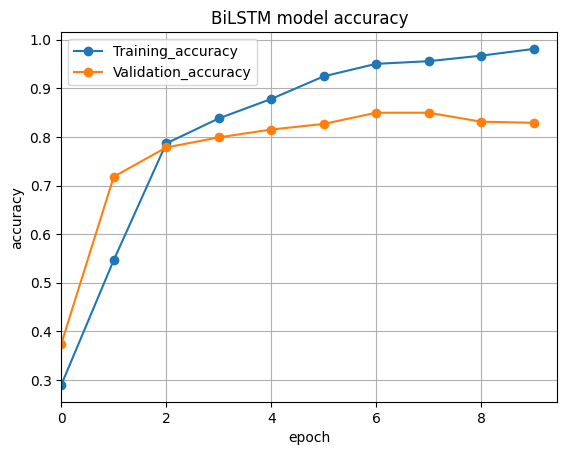

In [502]:
plt.plot(history_4.epoch, history_4.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('BiLSTM model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

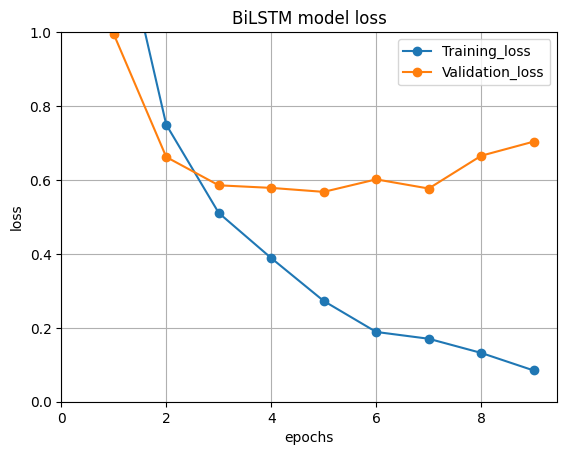

In [503]:
plt.plot(history_4.epoch, history_4.history['loss'], '-o', label='Training_loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='Validation_loss')
plt.legend()
plt.title('BiLSTM model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [504]:
# plot_classification_report(report)
# plt.savefig('BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.close()

AVG. Cross validation

In [505]:
df_results_cross_val.loc['BiLSTM avg cross validation data test 80%'] = [f1_avg_bilstm, precision_avg_bilstm, recall_avg_bilstm, accuracy_avg_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.804170,0.791103,0.792574,155.263662
CNN-BiLSTM avg cross validation data train 80%,0.792222,0.802292,0.792222,0.793069,122.956128
CNN-BiLSTM avg cross validation data test 20%,0.804681,0.808747,0.810249,0.810249,12.295613
1D_CNN avg cross validation data test 80%,0.805887,0.812323,0.805887,0.809406,42.454481
1D_CNN avg cross validation data test 20%,0.786249,0.801736,0.801939,0.801939,4.245448
BiLSTM avg cross validation data test 80%,0.812769,0.825436,0.812769,0.815347,290.757201


In [506]:
# Test cross validation 20%
model_bisltm_cross_validate = load_model(bisltm_cross_validate_model_path)
predicted = model_bisltm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

23/23 [==============================] - 1s 14ms/step
Testing Accuracy: 0.826870
Testing Precision: 0.828387
Testing Recall: 0.826870
Testing F1 score: 0.826447


In [507]:

df_results_cross_val.loc['BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.791103,0.804170,0.791103,0.792574,155.263662
CNN-BiLSTM avg cross validation data train 80%,0.792222,0.802292,0.792222,0.793069,122.956128
CNN-BiLSTM avg cross validation data test 20%,0.804681,0.808747,0.810249,0.810249,12.295613
1D_CNN avg cross validation data test 80%,0.805887,0.812323,0.805887,0.809406,42.454481
1D_CNN avg cross validation data test 20%,0.786249,0.801736,0.801939,0.801939,4.245448
BiLSTM avg cross validation data test 80%,0.812769,0.825436,0.812769,0.815347,290.757201
BiLSTM avg cross validation data test 20%,0.826447,0.828387,0.826870,0.826870,29.075720


## save the results in csv

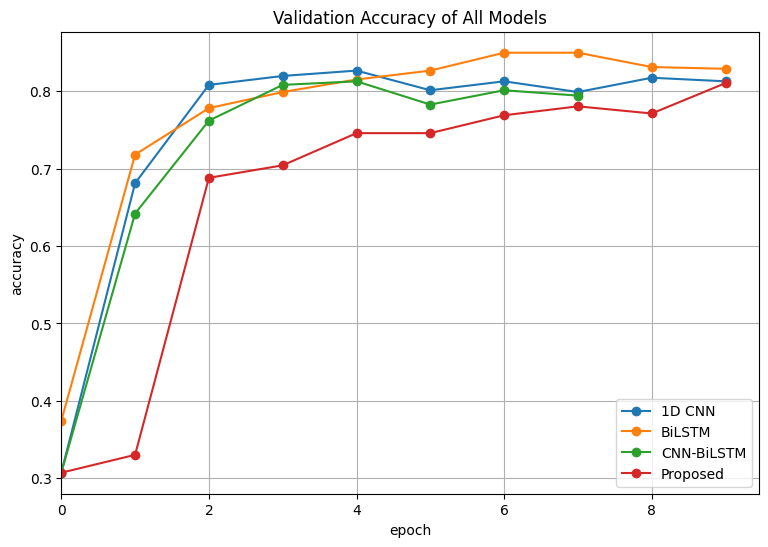

In [508]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_accuracy'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Proposed')
plt.title('Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

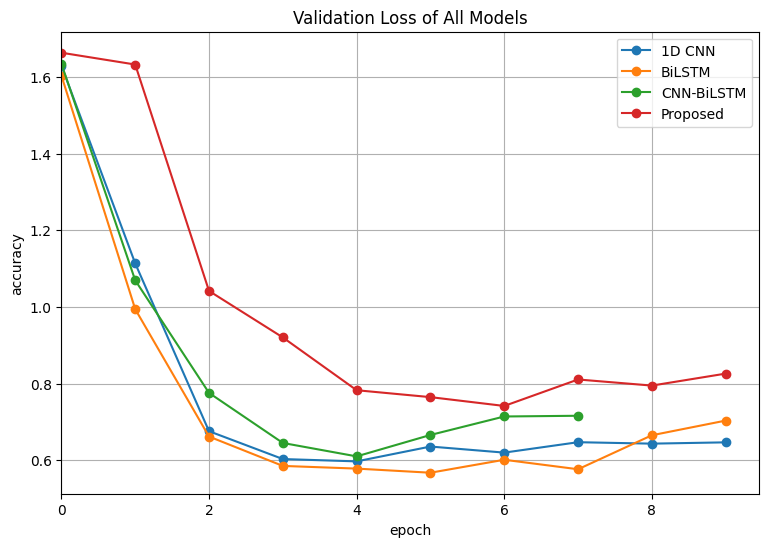

In [509]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_loss'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Proposed')
plt.title('Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()